# Imports and Setup

In [1]:
from pathlib import Path
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")

# Load and Explore Dataset

In [2]:
# Load the dataset
df = pd.read_csv('../datasets/raw/student_lifestyle_dataset.csv')

In [3]:
# Display basic information about the dataset
print("Shape of the dataset:", df.shape)
display(df.head())
print("\nDataset Information:")
print(df.info())
print("\nStatistical Summary:")
display(df.describe().T)

Shape of the dataset: (2000, 8)


Student_ID  Study_Hours_Per_Day  Extracurricular_Hours_Per_Day  \
0           1                  6.9                            3.8   
1           2                  5.3                            3.5   
2           3                  5.1                            3.9   
3           4                  6.5                            2.1   
4           5                  8.1                            0.6   

   Sleep_Hours_Per_Day  Social_Hours_Per_Day  Physical_Activity_Hours_Per_Day  \
0                  8.7                   2.8                              1.8   
1                  8.0                   4.2                              3.0   
2                  9.2                   1.2                              4.6   
3                  7.2                   1.7                              6.5   
4                  6.5                   2.2                              6.6   

    GPA Stress_Level  
0  2.99     Moderate  
1  2.75          Low  
2  2.67          Low  
3  2.88     Moderate  
4  3.51         High


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Student_ID                       2000 non-null   int64  
 1   Study_Hours_Per_Day              2000 non-null   float64
 2   Extracurricular_Hours_Per_Day    2000 non-null   float64
 3   Sleep_Hours_Per_Day              2000 non-null   float64
 4   Social_Hours_Per_Day             2000 non-null   float64
 5   Physical_Activity_Hours_Per_Day  2000 non-null   float64
 6   GPA                              2000 non-null   float64
 7   Stress_Level                     2000 non-null   object 
dtypes: float64(6), int64(1), object(1)
memory usage: 125.1+ KB
None

Statistical Summary:


count        mean         std   min     25%  \
Student_ID                       2000.0  1000.50000  577.494589  1.00  500.75   
Study_Hours_Per_Day              2000.0     7.47580    1.423888  5.00    6.30   
Extracurricular_Hours_Per_Day    2000.0     1.99010    1.155855  0.00    1.00   
Sleep_Hours_Per_Day              2000.0     7.50125    1.460949  5.00    6.20   
Social_Hours_Per_Day             2000.0     2.70455    1.688514  0.00    1.20   
Physical_Activity_Hours_Per_Day  2000.0     4.32830    2.514110  0.00    2.40   
GPA                              2000.0     3.11596    0.298674  2.24    2.90   

                                     50%      75%     max  
Student_ID                       1000.50  1500.25  2000.0  
Study_Hours_Per_Day                 7.40     8.70    10.0  
Extracurricular_Hours_Per_Day       2.00     3.00     4.0  
Sleep_Hours_Per_Day                 7.50     8.80    10.0  
Social_Hours_Per_Day                2.60     4.10     6.0  
Physical_Activity_Hours_Per_Day     4.10     6.10    13.0  
GPA                                 3.11     3.33     4.0

General Information

Dataset Size

* **Rows:** 2,000
* **Columns:** 8
* All columns are complete with no missing data

Data Types

* **Numeric Columns:** 6 (covering study, sleep, physical activity hours, and GPA)
* **Categorical Column:** 1 (**Stress_Level**)
* **ID Column:** 1 (**Student_ID**)

Initial Observations

Balanced Lifestyle

* On average, students spend similar amounts of time on studying, sleeping, and exercising, suggesting a fairly balanced daily routine.

GPA and Lifestyle

* The relatively high average GPA hints at a possible positive link between balanced habits—such as adequate sleep and study time—and academic results.

Stress Levels

* **Stress_Level** can be examined to explore connections with GPA and other lifestyle variables.

Outliers

* Some students have very high **Physical_Activity_Hours**, up to 13 hours per day.
* **Social_Hours** vary widely, reaching up to 6 hours daily, showing diverse social behaviors.


In [4]:
# Check for missing and duplicated values
print(f'\nMissing values: {df.isna().sum().sum()}')
print(f'Duplicated values: {df.duplicated().sum()}')


Missing values: 0
Duplicated values: 0


Missing and Duplicated Values

* **Missing Values:** 0.
  The dataset has no missing entries; every column is fully populated.

* **Duplicated Values:** 0.
  There are no repeated rows, ensuring each record is unique.


In [5]:
# Display the number of unique values in each column
print("\nUnique Values in Each Column:")
print(df.nunique())


Unique Values in Each Column:
Student_ID                         2000
Study_Hours_Per_Day                  51
Extracurricular_Hours_Per_Day        41
Sleep_Hours_Per_Day                  51
Social_Hours_Per_Day                 61
Physical_Activity_Hours_Per_Day     118
GPA                                 158
Stress_Level                          3
dtype: int64


In [6]:
# Separate numerical and categorical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
non_numerical_columns = df.select_dtypes(include=['object']).columns.tolist()

# Display the lists of numerical and categorical columns
print("\nNumerical Columns:", numerical_columns)
print("Categorical Columns:", non_numerical_columns)


Numerical Columns: ['Student_ID', 'Study_Hours_Per_Day', 'Extracurricular_Hours_Per_Day', 'Sleep_Hours_Per_Day', 'Social_Hours_Per_Day', 'Physical_Activity_Hours_Per_Day', 'GPA']
Categorical Columns: ['Stress_Level']


In [7]:
# Display unique values for each categorical column
for col in non_numerical_columns:
    print(f"\nColumn: {col}")
    print(f"Unique Values: {df[col].unique()}")


Column: Stress_Level
Unique Values: ['Moderate' 'Low' 'High']


Insights from Unique Value Exploration

Data Variety

* **Numerical Columns:** Features like **Study_Hours_Per_Day**, **Sleep_Hours_Per_Day**, and **Physical_Activity_Hours_Per_Day** show a wide range of unique values (51–118), reflecting varied daily routines among students.
* **GPA:** With 158 distinct values, academic performance is captured in a detailed and granular way.

Categorical Feature

* **Stress_Level:** Restricted to three categories (**Low**, **Moderate**, **High**), making it well-suited for classification and categorical analysis.

Unique Student Records

* Each student has a unique **Student_ID**, ensuring no duplicates and clear tracking for individual analysis.

Lifestyle Activities

* **Physical Activity:** The largest number of unique values (118) among lifestyle features, showing differences in students’ engagement with exercise.
* **Social Hours:** 61 unique values, highlighting the variety in social interactions.

Analysis Opportunities

* **Clustering Potential:** The wide ranges in **Study_Hours_Per_Day**, **Extracurricular_Hours_Per_Day**, and **Sleep_Hours_Per_Day** allow for grouping students based on lifestyle patterns.
* **GPA Granularity:** Detailed GPA values support precise performance analysis and modeling.
* **Balanced Categorical Data:** The three stress levels make it easy to study relationships between stress and lifestyle or academic features.


# Exploratory Data Analysis (EDA)

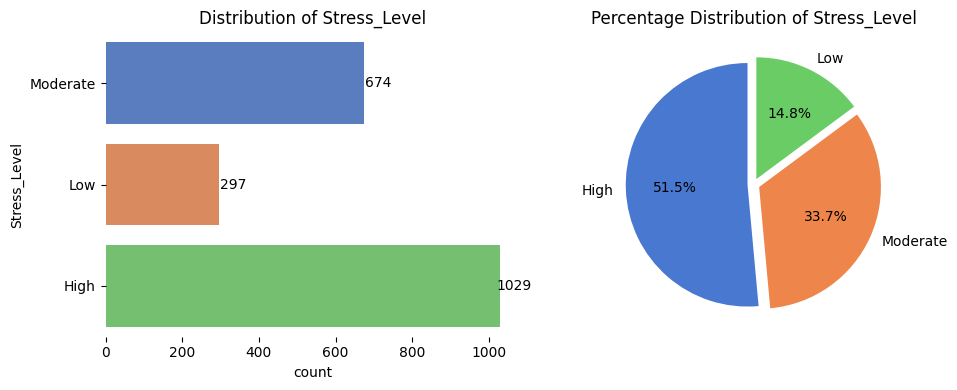

In [8]:
column_name = 'Stress_Level'
plt.figure(figsize=(10, 4))

# First subplot: Count plot
plt.subplot(1, 2, 1)
sns.countplot(y=column_name, data=df, palette='muted')  
plt.title(f'Distribution of {column_name}')

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='center', va='center', xytext=(10, 0), textcoords='offset points')

sns.despine(left=True, bottom=True)

# Second subplot: Pie chart
plt.subplot(1, 2, 2)
df[column_name].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('muted'), startangle=90, explode=[0.05]*df[column_name].nunique())
plt.title(f'Percentage Distribution of {column_name}')
plt.ylabel('')  

plt.tight_layout()
plt.show()

Insights

**Stress Level Distribution**

* **High Stress:** Most common, affecting 51.5% of students (1,029). This shows that over half of the students experience significant stress, likely influenced by academic, social, or lifestyle factors.
* **Moderate Stress:** Second most frequent, with 33.7% of students (674), indicating a sizable group managing stress reasonably well.
* **Low Stress:** Only 14.8% of students (297) fall into this category, suggesting that a small portion maintain a balanced, low-stress lifestyle.

**Key Observations**

* **High Stress Dominance:** The large number of students with high stress highlights the importance of investigating causes such as heavy workload, limited physical activity, or insufficient sleep.
* **Moderate Stress:** About a third of students manage stress moderately, showing a balance that is adequate but not ideal.
* **Low Stress as Minority:** Less than 15% of students have low stress, reflecting that very few achieve an optimal balance between academics, social life, and personal well-being.

**Implications**

* The majority (85.2%) face moderate to high stress, which could affect academic performance and overall health.
* Schools or researchers might consider strategies to reduce stress, such as encouraging adequate sleep, balanced social activities, and regular exercise.


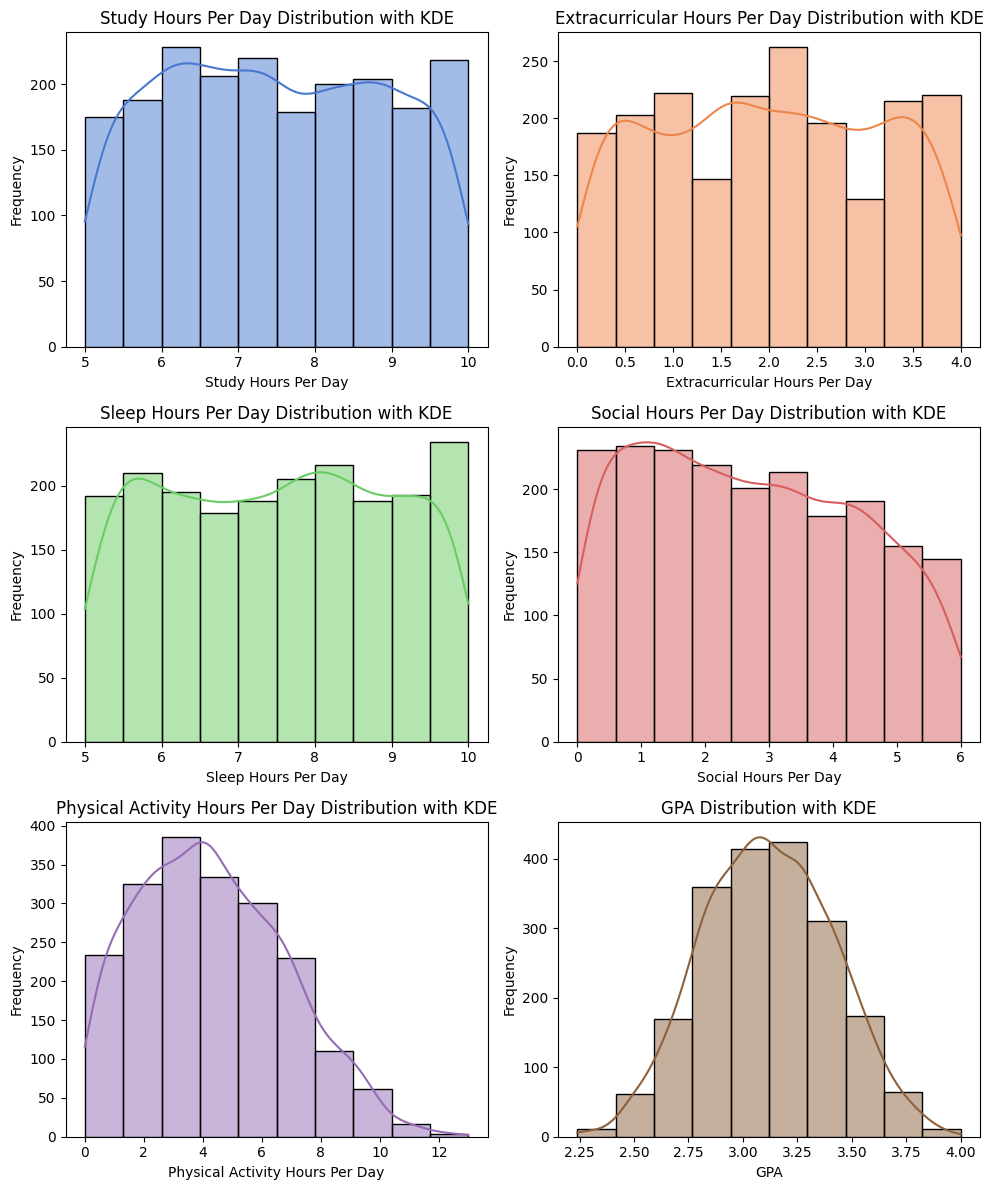

In [9]:
# Function to perform univariate analysis for numeric columns
def univariate_analysis(data, columns):
    plt.figure(figsize=(10, 12))  
    
    muted_colors = sns.color_palette("muted", len(columns))
    
    for i, column in enumerate(columns):
        plt.subplot(3, 2, i + 1)  
        sns.histplot(data[column], kde=True, bins=10, color=muted_colors[i])
        plt.title(f'{column.replace("_", " ")} Distribution with KDE')
        plt.xlabel(column.replace('_', ' '))
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

columns_to_analyze = ['Study_Hours_Per_Day', 'Extracurricular_Hours_Per_Day', 
                       'Sleep_Hours_Per_Day', 'Social_Hours_Per_Day', 
                       'Physical_Activity_Hours_Per_Day', 'GPA']

univariate_analysis(df, columns_to_analyze)

Insights on Daily Habits and GPA

**Study Hours Per Day**

* Slightly right-skewed distribution; most students study **6–8 hours daily**.
* Few dedicate **more than 9 hours** to studying.

**Extracurricular Hours Per Day**

* Left-skewed pattern; majority spend **0–2 hours** on extracurricular activities.
* A smaller group engages in **3–4 hours**.

**Sleep Hours Per Day**

* Nearly normal distribution, centered around **7–8 hours** of sleep.
* Very few students sleep **less than 6 hours** or **more than 9 hours**.

**Social Hours Per Day**

* Right-skewed; most spend **1–3 hours** socializing.
* Some students spend **4+ hours**, forming a smaller group.

**Physical Activity Hours Per Day**

* Right-skewed; majority engage in **2–5 hours** of physical activity daily.
* A few exceed **8 hours**, with outliers beyond **10 hours**.

**GPA**

* Fairly normal distribution, peaking around **3.0–3.2**.
* Few students reach near **4.0**, while very few fall below **2.5**.


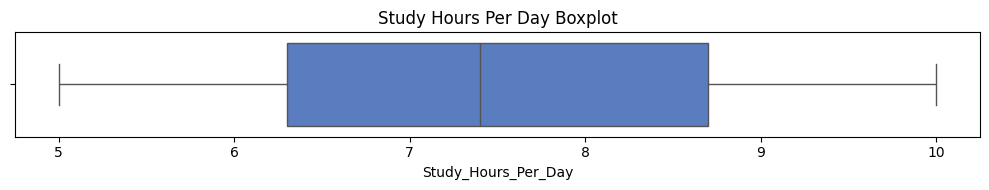


Summary Statistics for Study Hours Per Day:
 count    2000.000000
mean        7.475800
std         1.423888
min         5.000000
25%         6.300000
50%         7.400000
75%         8.700000
max        10.000000
Name: Study_Hours_Per_Day, dtype: float64


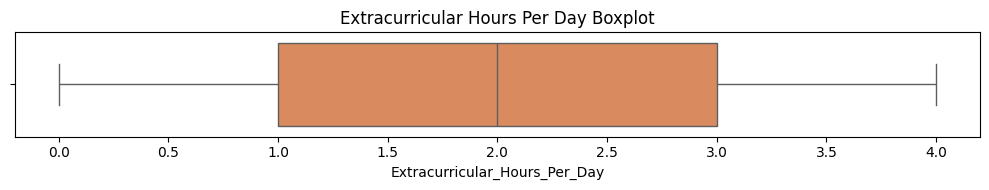


Summary Statistics for Extracurricular Hours Per Day:
 count    2000.000000
mean        1.990100
std         1.155855
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         4.000000
Name: Extracurricular_Hours_Per_Day, dtype: float64


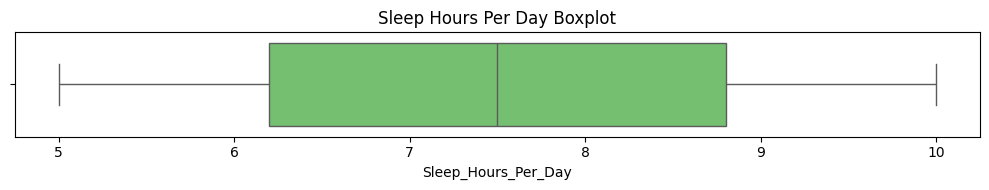


Summary Statistics for Sleep Hours Per Day:
 count    2000.000000
mean        7.501250
std         1.460949
min         5.000000
25%         6.200000
50%         7.500000
75%         8.800000
max        10.000000
Name: Sleep_Hours_Per_Day, dtype: float64


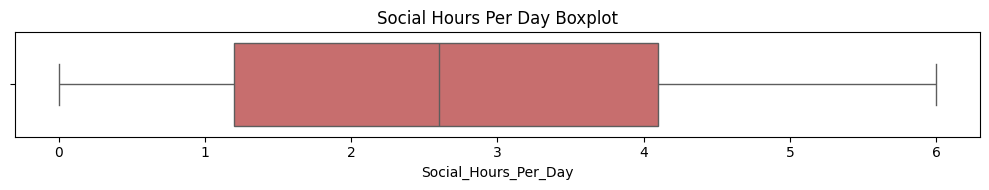


Summary Statistics for Social Hours Per Day:
 count    2000.000000
mean        2.704550
std         1.688514
min         0.000000
25%         1.200000
50%         2.600000
75%         4.100000
max         6.000000
Name: Social_Hours_Per_Day, dtype: float64


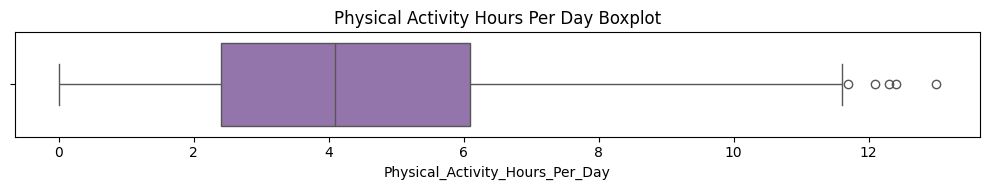


Summary Statistics for Physical Activity Hours Per Day:
 count    2000.00000
mean        4.32830
std         2.51411
min         0.00000
25%         2.40000
50%         4.10000
75%         6.10000
max        13.00000
Name: Physical_Activity_Hours_Per_Day, dtype: float64


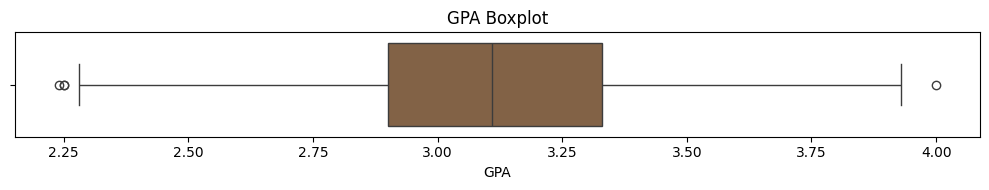


Summary Statistics for GPA:
 count    2000.000000
mean        3.115960
std         0.298674
min         2.240000
25%         2.900000
50%         3.110000
75%         3.330000
max         4.000000
Name: GPA, dtype: float64


In [10]:
# Function to perform univariate analysis for numeric columns
def univariate_analysis(data, column, title):
    plt.figure(figsize=(10, 2))
    
    # Define a muted color palette
    color = sns.color_palette("muted")[columns_to_analyze.index(column)]
    
    sns.boxplot(x=data[column], color=color)
    plt.title(f'{title} Boxplot')
    
    plt.tight_layout()
    plt.show()

    print(f'\nSummary Statistics for {title}:\n', data[column].describe())

# List of columns to analyze
columns_to_analyze = ['Study_Hours_Per_Day', 'Extracurricular_Hours_Per_Day', 
                       'Sleep_Hours_Per_Day', 'Social_Hours_Per_Day', 
                       'Physical_Activity_Hours_Per_Day', 'GPA']

# Iterate through columns and perform univariate analysis
for column in columns_to_analyze:
    univariate_analysis(df, column, column.replace('_', ' '))

Insights on Student Routines and GPA

**1. Study Hours Per Day**

* **Range:** 5–10 hours
* **Median:** 7.4 hours, close to the mean of 7.48 hours
* **IQR:** 6.3–8.7 hours
* Outliers are few, showing most students follow a consistent study routine

**2. Extracurricular Hours Per Day**

* **Range:** 0–4 hours
* **Median:** 2 hours, similar to the mean of 1.99 hours
* **IQR:** 1–3 hours
* Outliers are rare; most students participate moderately in extracurricular activities

**3. Sleep Hours Per Day**

* **Range:** 5–10 hours
* **Median:** 7.5 hours, equal to the mean of 7.50 hours
* **IQR:** 6.2–8.8 hours
* Minimal outliers suggest consistent sleep patterns

**4. Social Hours Per Day**

* **Range:** 0–6 hours
* **Median:** 2.6 hours, slightly below the mean of 2.70 hours
* **IQR:** 1.2–4.1 hours
* Outliers at both ends indicate diverse social habits

**5. Physical Activity Hours Per Day**

* **Range:** 0–13 hours
* **Median:** 4.1 hours, near the mean of 4.33 hours
* **IQR:** 2.4–6.1 hours
* Notable outliers show a few students engage in unusually high physical activity

**6. GPA**

* **Range:** 2.24–4.0
* **Median:** 3.11, close to the mean of 3.12
* **IQR:** 2.9–3.33
* Few outliers indicate most students achieve moderate to high academic performance

**Key Observations**

* **Consistent Patterns:** Study hours, sleep, and GPA have limited outliers, reflecting uniform behaviors among students
* **Varied Engagement:** Social and physical activity hours show greater variability, highlighting different lifestyle choices and habits


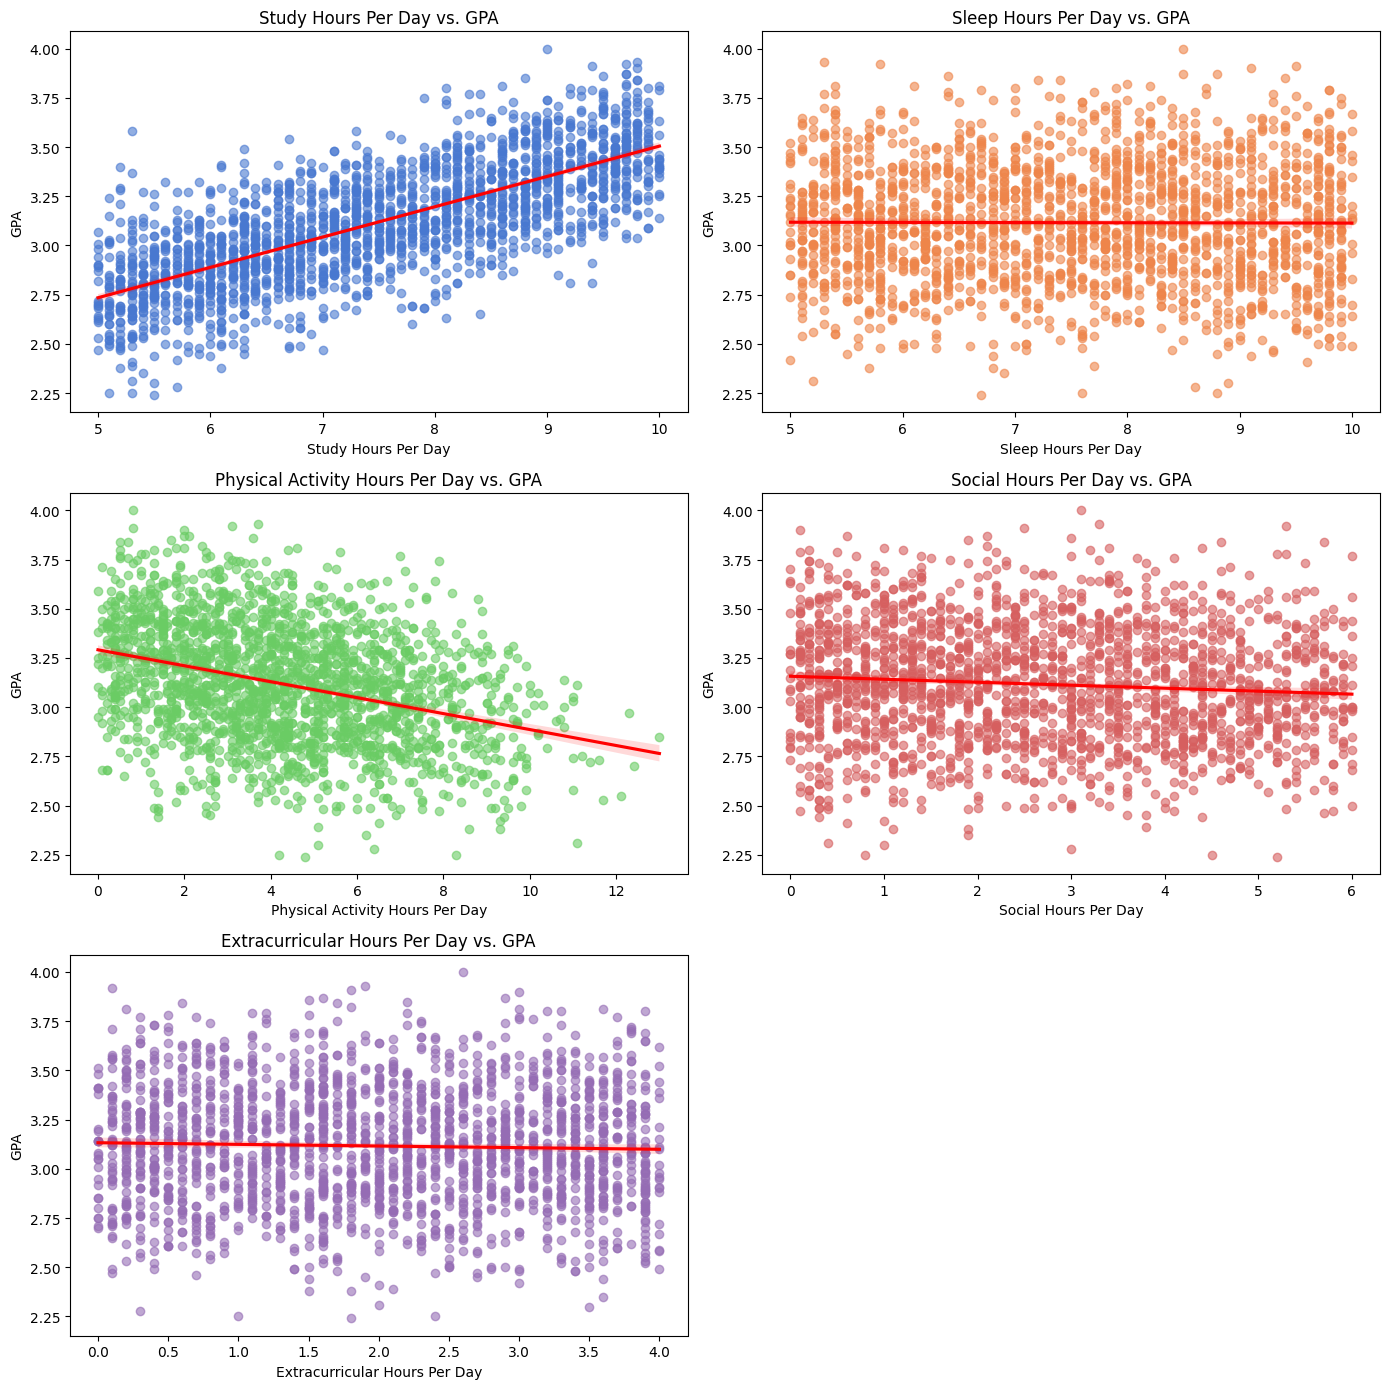

In [11]:
# Define muted colors from the palette
muted_colors = sns.color_palette("muted")

# Scatter plots with linear regression lines 
plt.figure(figsize=(14, 14))

# Study Hours vs. GPA
plt.subplot(3, 2, 1)
sns.regplot(x='Study_Hours_Per_Day', y='GPA', data=df,
            color=muted_colors[0], scatter_kws={'alpha':0.6}, line_kws={'color': 'red'})
plt.title('Study Hours Per Day vs. GPA')
plt.xlabel('Study Hours Per Day')
plt.ylabel('GPA')

# Sleep Hours vs. GPA
plt.subplot(3, 2, 2)
sns.regplot(x='Sleep_Hours_Per_Day', y='GPA', data=df,
            color=muted_colors[1], scatter_kws={'alpha':0.6}, line_kws={'color': 'red'})
plt.title('Sleep Hours Per Day vs. GPA')
plt.xlabel('Sleep Hours Per Day')
plt.ylabel('GPA')

# Physical Activity Hours vs. GPA
plt.subplot(3, 2, 3)
sns.regplot(x='Physical_Activity_Hours_Per_Day', y='GPA', data=df,
            color=muted_colors[2], scatter_kws={'alpha':0.6}, line_kws={'color': 'red'})
plt.title('Physical Activity Hours Per Day vs. GPA')
plt.xlabel('Physical Activity Hours Per Day')
plt.ylabel('GPA')

# Social Hours vs. GPA
plt.subplot(3, 2, 4)
sns.regplot(x='Social_Hours_Per_Day', y='GPA', data=df,
            color=muted_colors[3], scatter_kws={'alpha':0.6}, line_kws={'color': 'red'})
plt.title('Social Hours Per Day vs. GPA')
plt.xlabel('Social Hours Per Day')
plt.ylabel('GPA')

# Extracurricular Hours vs. GPA
plt.subplot(3, 2, 5)
sns.regplot(x='Extracurricular_Hours_Per_Day', y='GPA', data=df,
            color=muted_colors[4], scatter_kws={'alpha':0.6}, line_kws={'color': 'red'})
plt.title('Extracurricular Hours Per Day vs. GPA')
plt.xlabel('Extracurricular Hours Per Day')
plt.ylabel('GPA')

plt.tight_layout()
plt.show()

Insights on Linear Relationships

**Study Hours Per Day vs. GPA**

* **Strong Positive Relationship:** As study hours increase, GPA rises noticeably.
* This confirms that spending more time studying generally improves academic performance.

**Sleep Hours Per Day vs. GPA**

* **No Clear Relationship:** The regression line is nearly flat, showing little to no correlation.
* Variations in sleep do not appear to affect GPA, provided students get a reasonable amount of rest.

**Physical Activity Hours Per Day vs. GPA**

* **Moderate Negative Relationship:** Slight downward trend; more physical activity is linked to a small decrease in GPA.
* Suggests a minor trade-off between exercise time and academic focus, though the effect is limited.

**Social Hours Per Day vs. GPA**

* **Weak Negative Relationship:** A slight downward slope indicates that excessive socializing may slightly reduce GPA.
* Moderate social interaction is generally harmless for academic performance.

**Extracurricular Hours Per Day vs. GPA**

* **No Significant Relationship:** The regression line is flat, indicating extracurricular involvement does not directly affect GPA.

**Overall Observations**

* **Study Hours Matter Most:** They have the strongest positive impact on GPA.
* **Balanced Lifestyle:** Physical activity and social time have minor negative effects but are important for overall well-being.
* **Sleep is Neutral:** Adequate sleep doesn’t significantly change GPA.


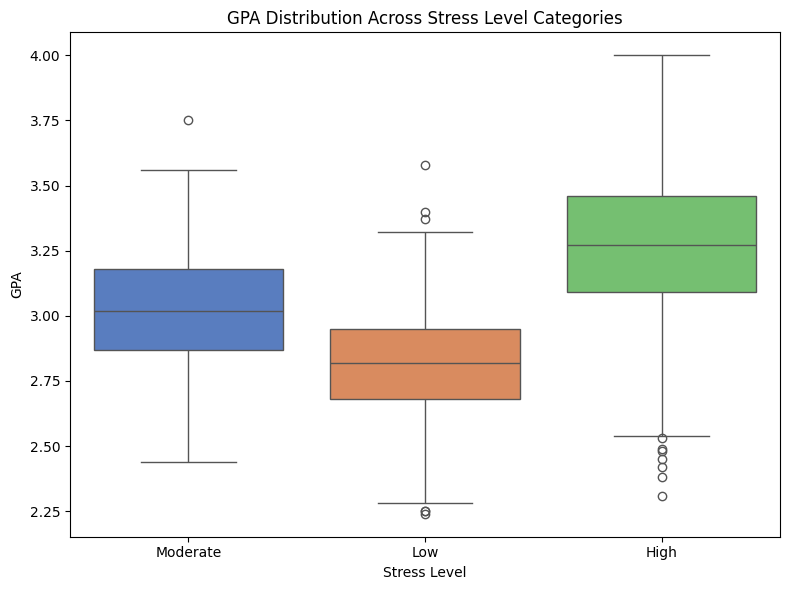

In [12]:
# Boxplot for GPA across different Stress_Level categories
plt.figure(figsize=(8, 6))
sns.boxplot(x='Stress_Level', y='GPA', data=df, palette='muted')

plt.title('GPA Distribution Across Stress Level Categories')
plt.xlabel('Stress Level')
plt.ylabel('GPA')

# Display the plot
plt.tight_layout()
plt.show()

Insights on GPA by Stress Level

**Low Stress**

* **Median GPA:** Slightly lower than other groups
* **Spread:** Narrow IQR, indicating more consistent but lower GPAs
* **Insight:** Students with low stress may not reach top GPAs, possibly due to less academic pressure

**Moderate Stress**

* **Median GPA:** Slightly higher than low stress students
* **Spread:** Wider IQR, showing varied academic performance
* **Insight:** Moderate stress appears ideal for balancing productivity and achieving good results

**High Stress**

* **Median GPA:** Highest among all groups
* **Spread:** Widest IQR, with both high achievers and some low outliers
* **Insight:** High stress can drive excellence for some students but negatively affect others

**Key Observations**

* **Moderate Stress:** Tends to support stable, above-average GPA and may be the optimal stress level
* **High Stress:** Acts as a double-edged sword—can boost performance for some while harming others
* **Low Stress:** Generally linked to lower median GPA, suggesting minimal pressure may not maximize academic output

**Conclusion**

* Achieving a balanced stress level seems crucial for optimal academic outcomes.


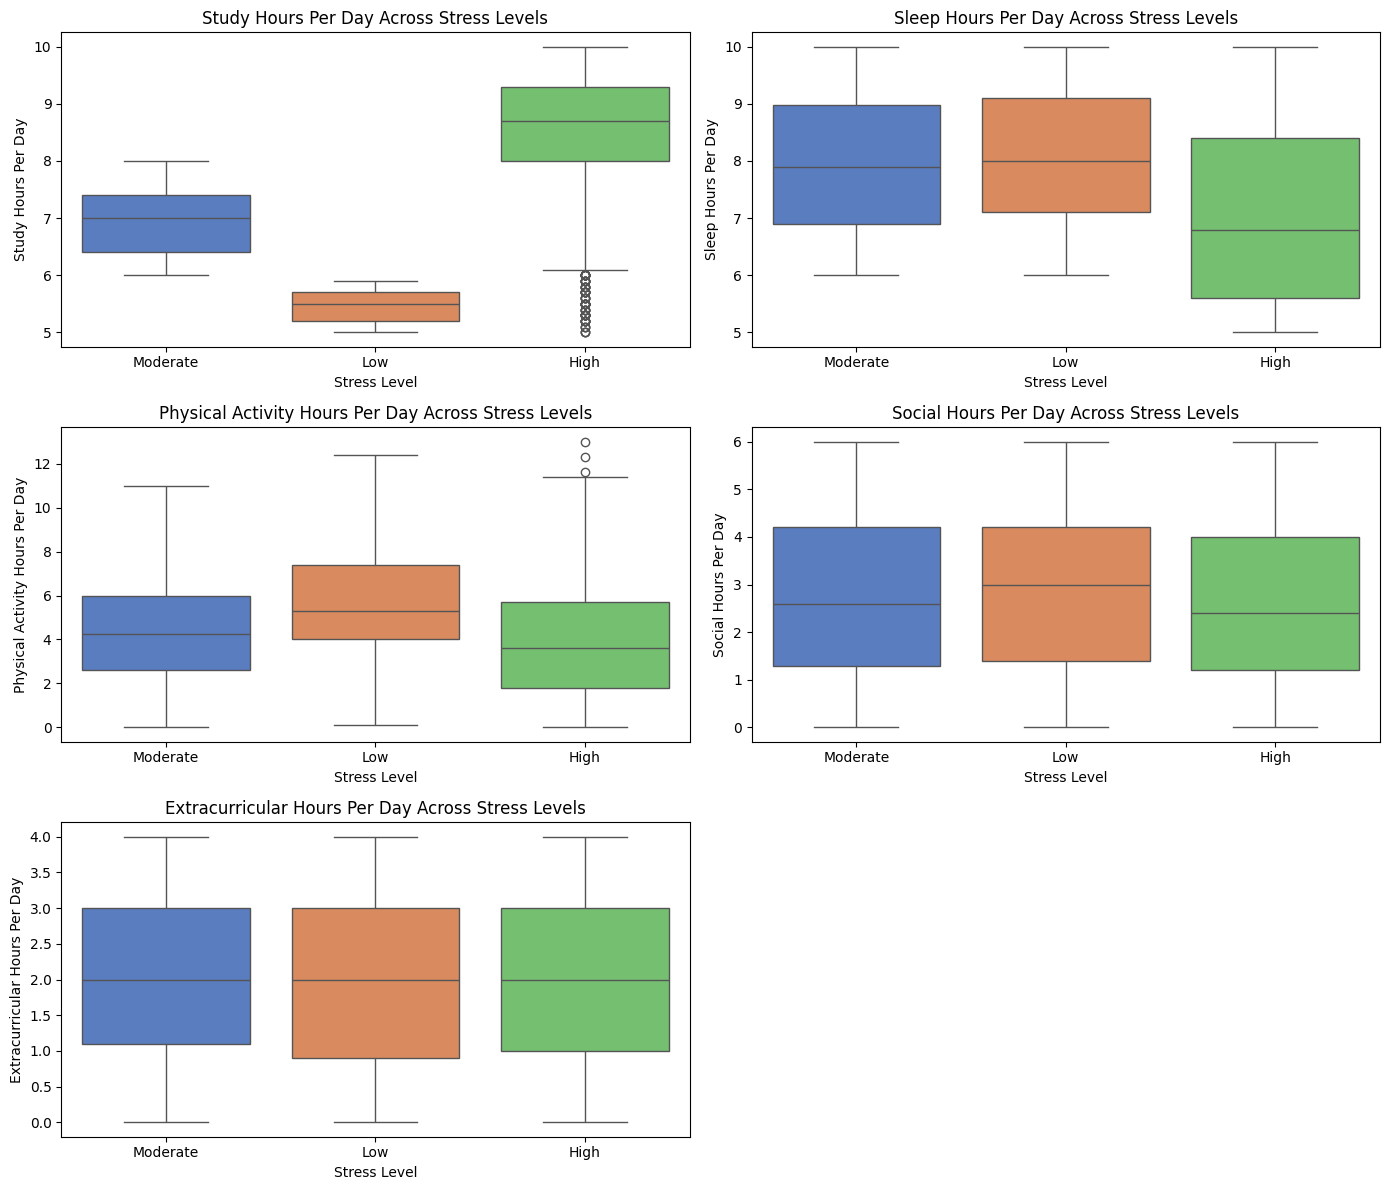

In [13]:
numerical_features = [
    'Study_Hours_Per_Day', 
    'Sleep_Hours_Per_Day', 
    'Physical_Activity_Hours_Per_Day', 
    'Social_Hours_Per_Day', 
    'Extracurricular_Hours_Per_Day'
]

# Create boxplots for each numerical feature grouped by Stress_Level
plt.figure(figsize=(14, 12))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x='Stress_Level', y=feature, data=df, palette='muted')
    plt.title(f'{feature.replace("_", " ")} Across Stress Levels')
    plt.xlabel('Stress Level')
    plt.ylabel(feature.replace("_", " "))

plt.tight_layout()
plt.show()

Insights on Daily Activities by Stress Level

**Study Hours Per Day**

* **High Stress:** Students study the most and have a wider range of hours, likely contributing to higher stress.
* **Moderate Stress:** Median study hours are lower than high stress but still significant.
* **Low Stress:** Students study the least, reflecting a more relaxed academic approach.

**Sleep Hours Per Day**

* **High Stress:** Slightly higher median sleep, but overall range is similar across stress levels.
* **Moderate & Low Stress:** Sleep patterns are fairly consistent, indicating stress has little effect on sleep duration.

**Physical Activity Hours Per Day**

* **Moderate & Low Stress:** Students engage in more physical activity, potentially as a stress management strategy.
* **High Stress:** Lower median physical activity; academic demands likely reduce exercise time.

**Social Hours Per Day**

* Median and range are similar for all stress groups.
* Social interaction remains steady regardless of stress level.

**Extracurricular Hours Per Day**

* Medians and ranges are consistent across stress levels.
* Participation in extracurriculars does not appear strongly influenced by stress.

**Key Observations**

* **Study Hours:** Closely linked to stress; more study correlates with higher stress.
* **Physical Activity:** More common among low- and moderate-stress students; high-stress students prioritize academics.
* **Sleep & Socializing:** Minimal variation, suggesting less impact from stress.
* **Extracurricular Activities:** Uniform distribution, showing stress has little effect on participation.


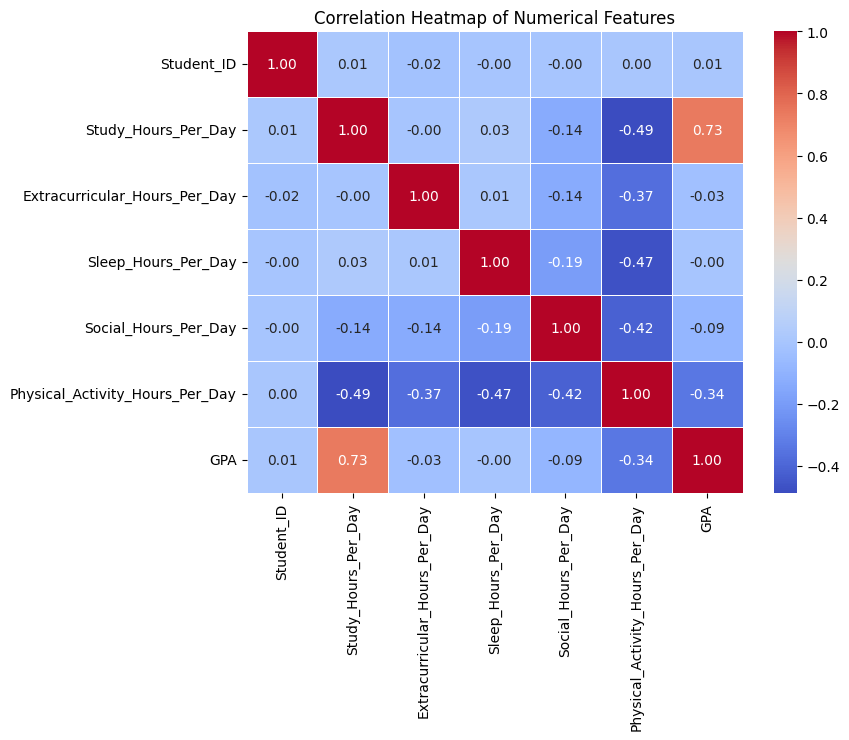

In [14]:
# Plotting a correlation heatmap for numerical variables
plt.figure(figsize=(8, 6))
numerical_columns = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_columns.corr()

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

Observational Insights from the Correlation Heatmap

**Key Correlations**

* **Study Hours & GPA:**
  Strong positive correlation (**0.73**). Students who dedicate more time to studying generally achieve higher GPAs, highlighting the importance of consistent study.

* **Physical Activity & Study Hours:**
  Moderate negative correlation (**-0.49**). More time spent exercising tends to reduce study hours, likely due to time limitations.

* **Physical Activity & GPA:**
  Moderate negative correlation (**-0.34**). Higher physical activity may slightly lower GPA, possibly because it limits study time.

* **Social Hours & GPA:**
  Weak negative correlation (**-0.09**). Socializing has minimal impact on GPA, though excessive social time might slightly reduce academic performance.

* **Extracurricular Hours & GPA:**
  Near zero correlation (**-0.03**). Participation in extracurriculars appears to have little direct effect on GPA.

* **Sleep Hours & GPA:**
  No meaningful correlation (**0.00**). Sleep duration does not directly affect GPA, though indirect benefits like improved focus could still be relevant.

**Overall Observations**

* **Study Hours** are the strongest predictor of GPA.
* **Physical Activity** has a moderate trade-off with study and academic performance, emphasizing the need for balance.
* **Social and Extracurricular Hours** have minimal direct effect on GPA but may impact stress and overall well-being.


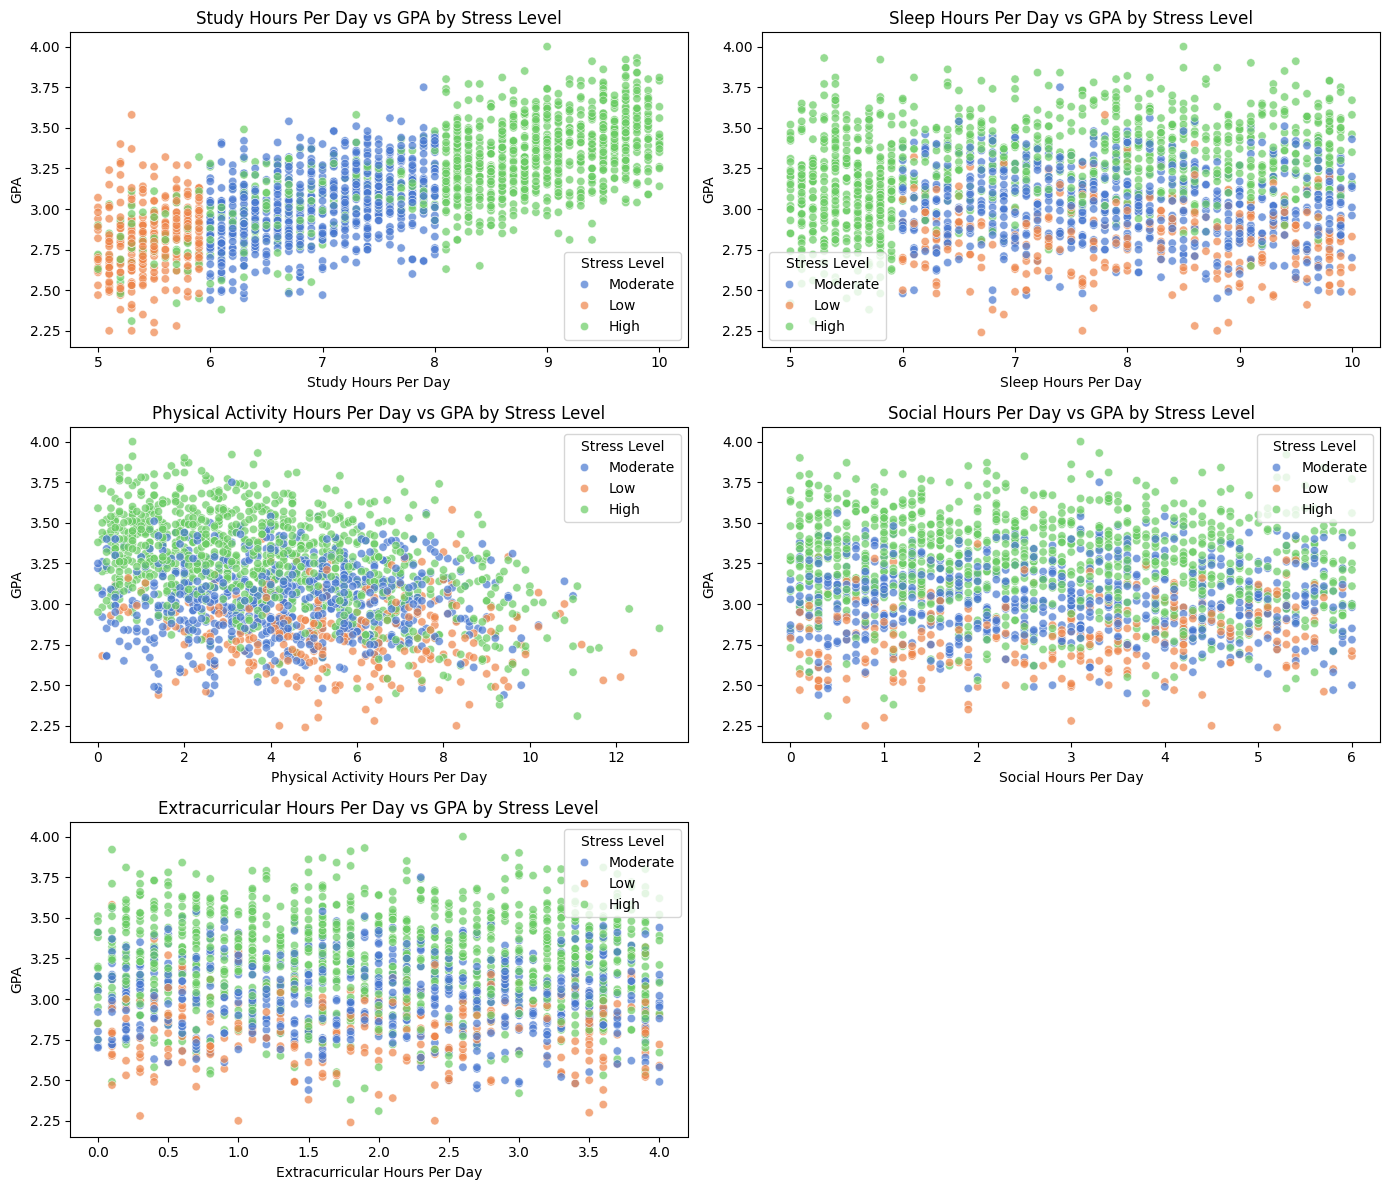

In [15]:
# Numerical features against GPA, grouped by Stress_Level
plt.figure(figsize=(14, 12))

numerical_features = [
    'Study_Hours_Per_Day', 
    'Sleep_Hours_Per_Day', 
    'Physical_Activity_Hours_Per_Day', 
    'Social_Hours_Per_Day', 
    'Extracurricular_Hours_Per_Day'
]

# Plot each feature
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(
        x=feature, 
        y='GPA', 
        hue='Stress_Level', 
        data=df, 
        palette='muted', 
        alpha=0.7
    )
    plt.title(f'{feature.replace("_", " ")} vs GPA by Stress Level')
    plt.xlabel(feature.replace('_', ' '))
    plt.ylabel('GPA')
    plt.legend(title='Stress Level')

plt.tight_layout()
plt.show()


Insights from Numerical Variables vs. GPA by Stress Level

**Study Hours Per Day vs. GPA**

* **High Stress:** Students studying more while under high stress often achieve higher GPAs.
* **Moderate Stress:** Those with moderate stress and reasonable study hours display a wide GPA range, showing balance is important.
* **Low Stress:** Students with low stress tend to have moderate GPAs, regardless of study hours.

**Sleep Hours Per Day vs. GPA**

* No clear pattern across any stress level.
* High-GPA students are spread across different sleep durations.
* **Insight:** Sleep duration doesn’t significantly affect GPA within any stress category.

**Physical Activity Hours Per Day vs. GPA**

* **High Stress:** Students generally exercise less; those who do show varied GPAs.
* **Moderate Stress:** Moderate activity levels are linked to decent GPAs with diverse outcomes.
* **Low Stress:** Higher physical activity shows wide-ranging GPAs, suggesting limited direct impact on performance.

**Social Hours Per Day vs. GPA**

* No strong correlation across stress levels.
* **High Stress:** GPAs remain fairly consistent despite varying social hours.
* **Moderate Stress:** Social hours vary widely, but GPA distribution stays even.
* **Low Stress:** Similar trend; social interaction has minimal influence on GPA.

**Extracurricular Hours Per Day vs. GPA**

* Across all stress levels, no clear link between extracurricular hours and GPA.
* Students participating in 0–4 hours of activities maintain varied GPAs, indicating these activities don’t directly drive academic outcomes, though excessive involvement might slightly hinder performance.


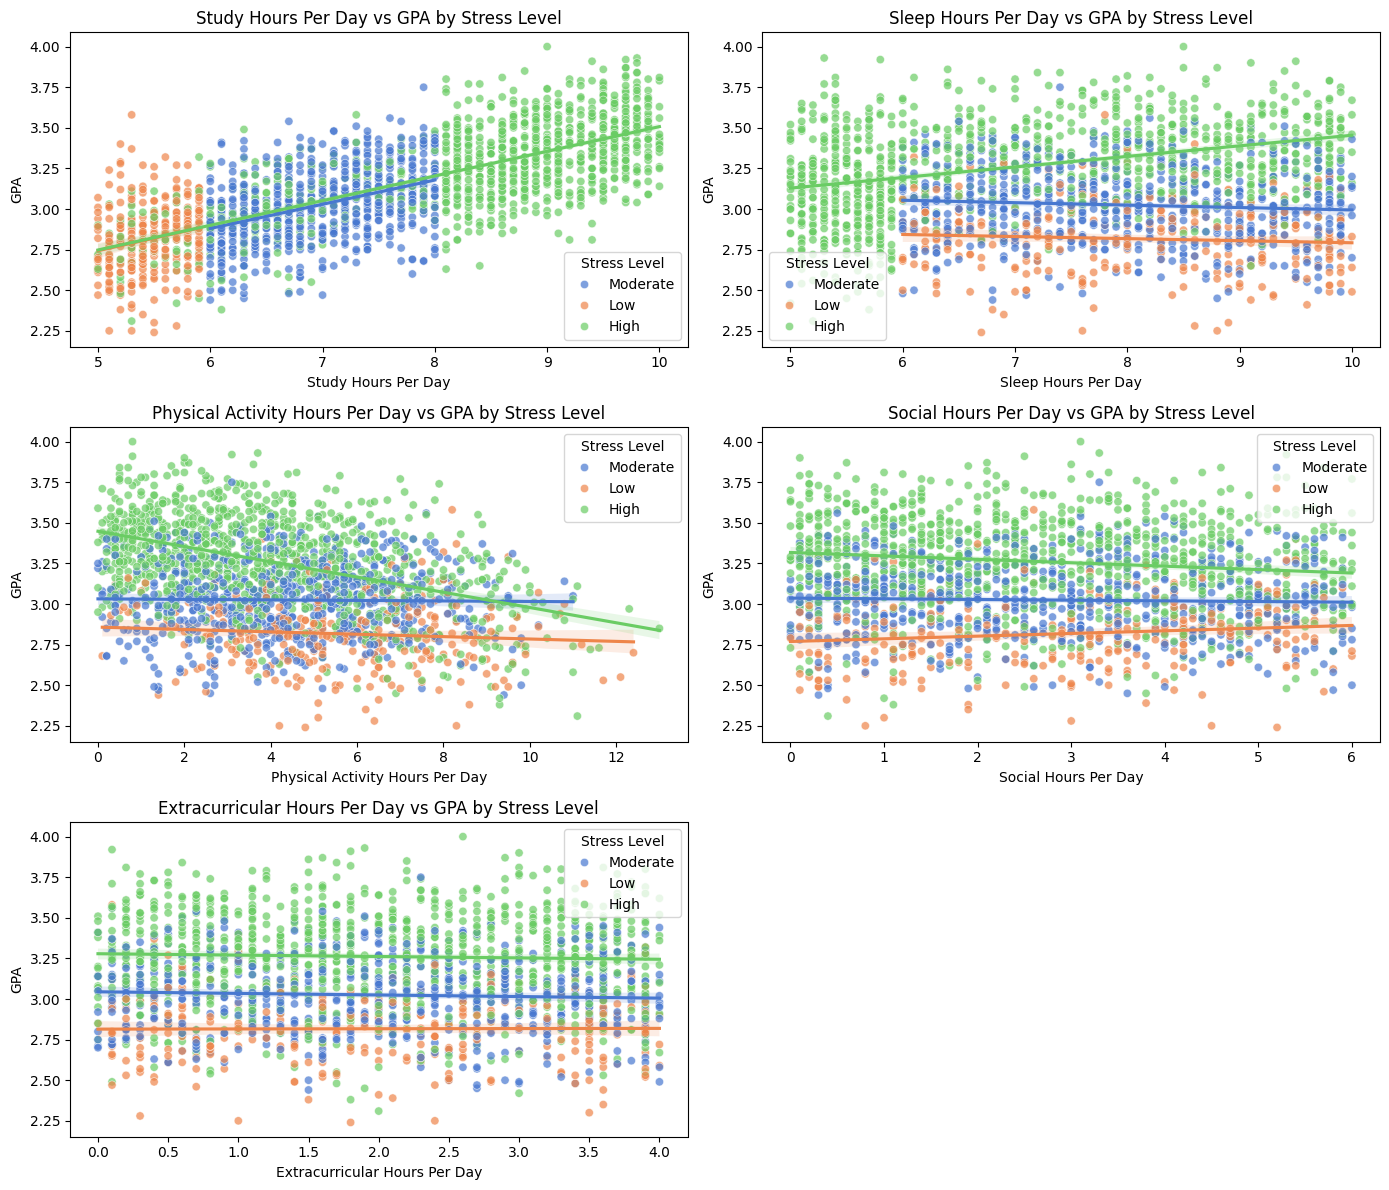

In [16]:
plt.figure(figsize=(14, 12))

numerical_features = [
    'Study_Hours_Per_Day', 
    'Sleep_Hours_Per_Day', 
    'Physical_Activity_Hours_Per_Day', 
    'Social_Hours_Per_Day', 
    'Extracurricular_Hours_Per_Day'
]

# Define colors for different stress levels
stress_colors = sns.color_palette('muted')

# Plot each feature
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 2, i + 1)
    
    # Scatter plot with matching colors for stress levels
    sns.scatterplot(
        x=feature,
        y='GPA',
        hue='Stress_Level',
        data=df,
        palette=stress_colors,
        alpha=0.7
    )
    
    # Add linear regression lines for each stress level with matching colors
    for j, stress_level in enumerate(df['Stress_Level'].unique()):
        sns.regplot(
            x=feature,
            y='GPA',
            data=df[df['Stress_Level'] == stress_level],
            scatter=False,
            color=stress_colors[j], # Use the same color for the line as in the scatter plot
            line_kws={'label': stress_level}
        )
    
    plt.title(f'{feature.replace("_", " ")} vs GPA by Stress Level')
    plt.xlabel(feature.replace('_', ' '))
    plt.ylabel('GPA')
    plt.legend(title='Stress Level')

plt.tight_layout()
plt.show()

Insights from Scatter Plots with Linear Regression

**Study Hours**

* Strong positive correlation with GPA, particularly for students experiencing **high** and **moderate stress**.
* More study time generally leads to better academic performance.

**Physical Activity**

* High activity levels may slightly lower GPA for **high-stress** students.
* Suggests a minor trade-off between exercise and study time under stress.

**Sleep, Social, and Extracurricular Hours**

* These factors show minimal direct impact on GPA across all stress levels.
* Their influence is likely indirect, supporting overall well-being rather than academic outcomes.

**Stress Levels**

* **High Stress:** Strengthens the link between study hours and GPA.
* **Low Stress:** Weakens the study–GPA relationship, indicating less academic pressure.


In [17]:
# Define thresholds for low and high GPA
low_gpa_threshold = 2.5
high_gpa_threshold = 3.5  

# Filter students with low GPA (less than or equal to the threshold)
low_gpa_students = df[df['GPA'] <= low_gpa_threshold][
    ['GPA', 'Study_Hours_Per_Day', 'Physical_Activity_Hours_Per_Day', 'Stress_Level']
]

# Display results in a clear format
print("----- Students with Low GPA (<= 2.5) -----")
display(low_gpa_students)

# Filter students with high GPA (equal to the threshold)
high_gpa_students = df[df['GPA'] >= high_gpa_threshold][
    ['GPA', 'Study_Hours_Per_Day', 'Physical_Activity_Hours_Per_Day', 'Stress_Level']
]

# Display results in a clear format
print("\n----- Students with High GPA (>= 3.5) -----")
display(high_gpa_students)

----- Students with Low GPA (<= 2.5) -----


GPA  Study_Hours_Per_Day  Physical_Activity_Hours_Per_Day Stress_Level
32    2.47                  5.2                              7.9          Low
56    2.39                  5.3                              5.1          Low
134   2.45                  6.3                              2.6     Moderate
158   2.38                  6.1                              9.3         High
165   2.46                  5.8                              2.5          Low
283   2.50                  6.2                              9.8     Moderate
331   2.25                  5.1                              8.3          Low
377   2.28                  5.7                              6.4          Low
382   2.31                  5.3                             11.1         High
504   2.49                  5.2                              4.6          Low
505   2.44                  6.0                              9.4     Moderate
512   2.49                  6.7                              9.1         High
550   2.48                  6.7                              7.5     Moderate
605   2.41                  5.3                              6.5          Low
651   2.49                  5.3                              6.3          Low
659   2.49                  6.1                              1.4     Moderate
742   2.48                  5.2                              6.0         High
764   2.24                  5.5                              4.8          Low
815   2.50                  5.6                              5.5          Low
862   2.45                  5.9                              6.9         High
901   2.48                  6.3                              5.2     Moderate
934   2.49                  5.1                              9.2          Low
997   2.49                  5.8                              9.5          Low
1034  2.38                  5.2                              8.6          Low
1074  2.44                  5.5                              1.4          Low
1122  2.50                  6.0                              2.7     Moderate
1172  2.30                  5.5                              5.1          Low
1388  2.50                  5.7                              6.8          Low
1427  2.47                  7.0                              1.4     Moderate
1443  2.42                  5.7                              9.3         High
1574  2.25                  5.3                              4.2          Low
1686  2.50                  5.1                              5.6          Low
1700  2.35                  5.4                              6.2          Low
1727  2.49                  6.8                              1.3     Moderate
1734  2.50                  6.1                              2.5     Moderate
1851  2.48                  5.9                              7.0          Low
1857  2.47                  5.0                              5.5          Low


----- Students with High GPA (>= 3.5) -----


GPA  Study_Hours_Per_Day  Physical_Activity_Hours_Per_Day Stress_Level
4     3.51                  8.1                              6.6         High
34    3.62                  9.7                              6.3         High
45    3.55                  9.7                              0.6         High
51    4.00                  9.0                              0.8         High
60    3.67                  8.3                              1.3         High
...    ...                  ...                              ...          ...
1939  3.52                  8.1                              2.4         High
1962  3.59                  9.4                              2.9         High
1964  3.54                  9.9                              3.0         High
1987  3.86                  9.5                              3.6         High
1999  3.58                  9.0                              2.9         High

[221 rows x 4 columns]

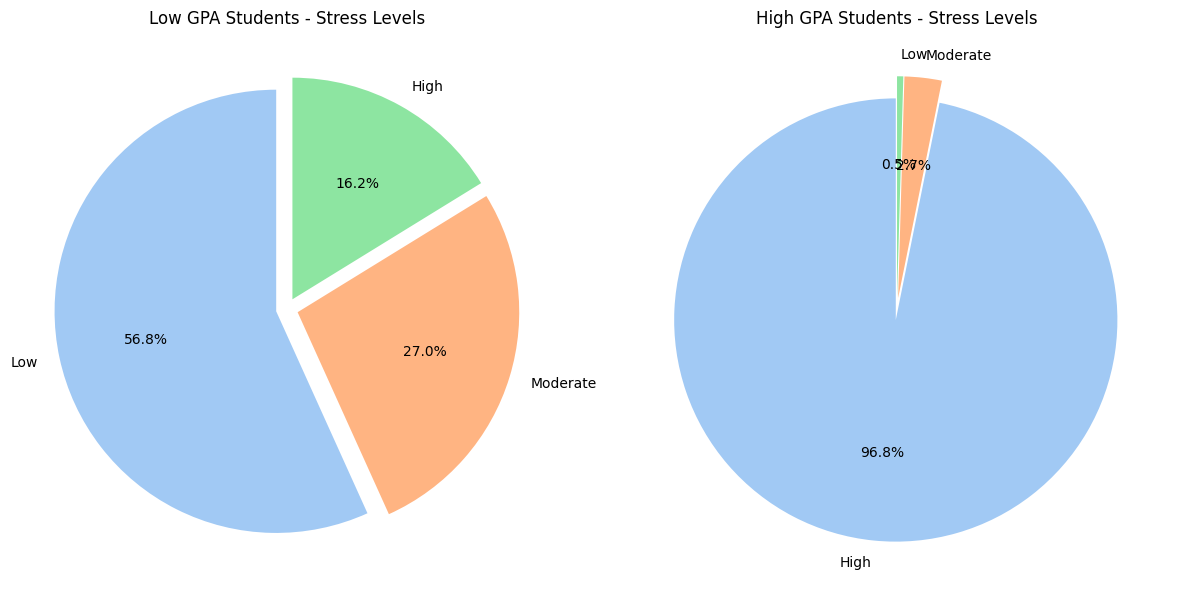

In [18]:
# Prepare data for low GPA students' stress levels
low_gpa_stress_counts = low_gpa_students['Stress_Level'].value_counts()

# Prepare data for high GPA students' stress levels
high_gpa_stress_counts = high_gpa_students['Stress_Level'].value_counts()

# Create subplots for pie charts
plt.figure(figsize=(12, 6))

# Low GPA students' stress levels pie chart
plt.subplot(1, 2, 1)
low_gpa_stress_counts.plot.pie(
    autopct='%1.1f%%', 
    colors=sns.color_palette('pastel'), 
    startangle=90, 
    explode=[0.05] * len(low_gpa_stress_counts), 
    labels=low_gpa_stress_counts.index
)
plt.title('Low GPA Students - Stress Levels')
plt.ylabel('')  

# High GPA students' stress levels pie chart
plt.subplot(1, 2, 2)
high_gpa_stress_counts.plot.pie(
    autopct='%1.1f%%', 
    colors=sns.color_palette('pastel'), 
    startangle=90, 
    explode=[0.05] * len(high_gpa_stress_counts), 
    labels=high_gpa_stress_counts.index
)
plt.title('High GPA Students - Stress Levels')
plt.ylabel('')  

# Show the plots
plt.tight_layout()
plt.show()

Insights on Stress Levels Among Low and High GPA Students

**Low GPA Students**

* **Low Stress:** 56.8% fall into this category, possibly reflecting less academic motivation or pressure.
* **Moderate Stress:** 27.0% experience moderate stress.
* **High Stress:** 16.2% face high stress, suggesting excessive stress can negatively affect performance.

**High GPA Students**

* **High Stress:** 96.8% experience high stress, indicating strong academic drive linked to stress.
* **Moderate Stress:** Only 2.7% report moderate stress.
* **Low Stress:** A tiny 0.5% report low stress, implying minimal stress rarely leads to top performance.

**Key Observations**

* **Stress and GPA:** High stress is common among high-achieving students, while low stress is typical among lower GPA students.
* **Moderate Stress:** Appears to support stable academic performance but is less prevalent among top performers.


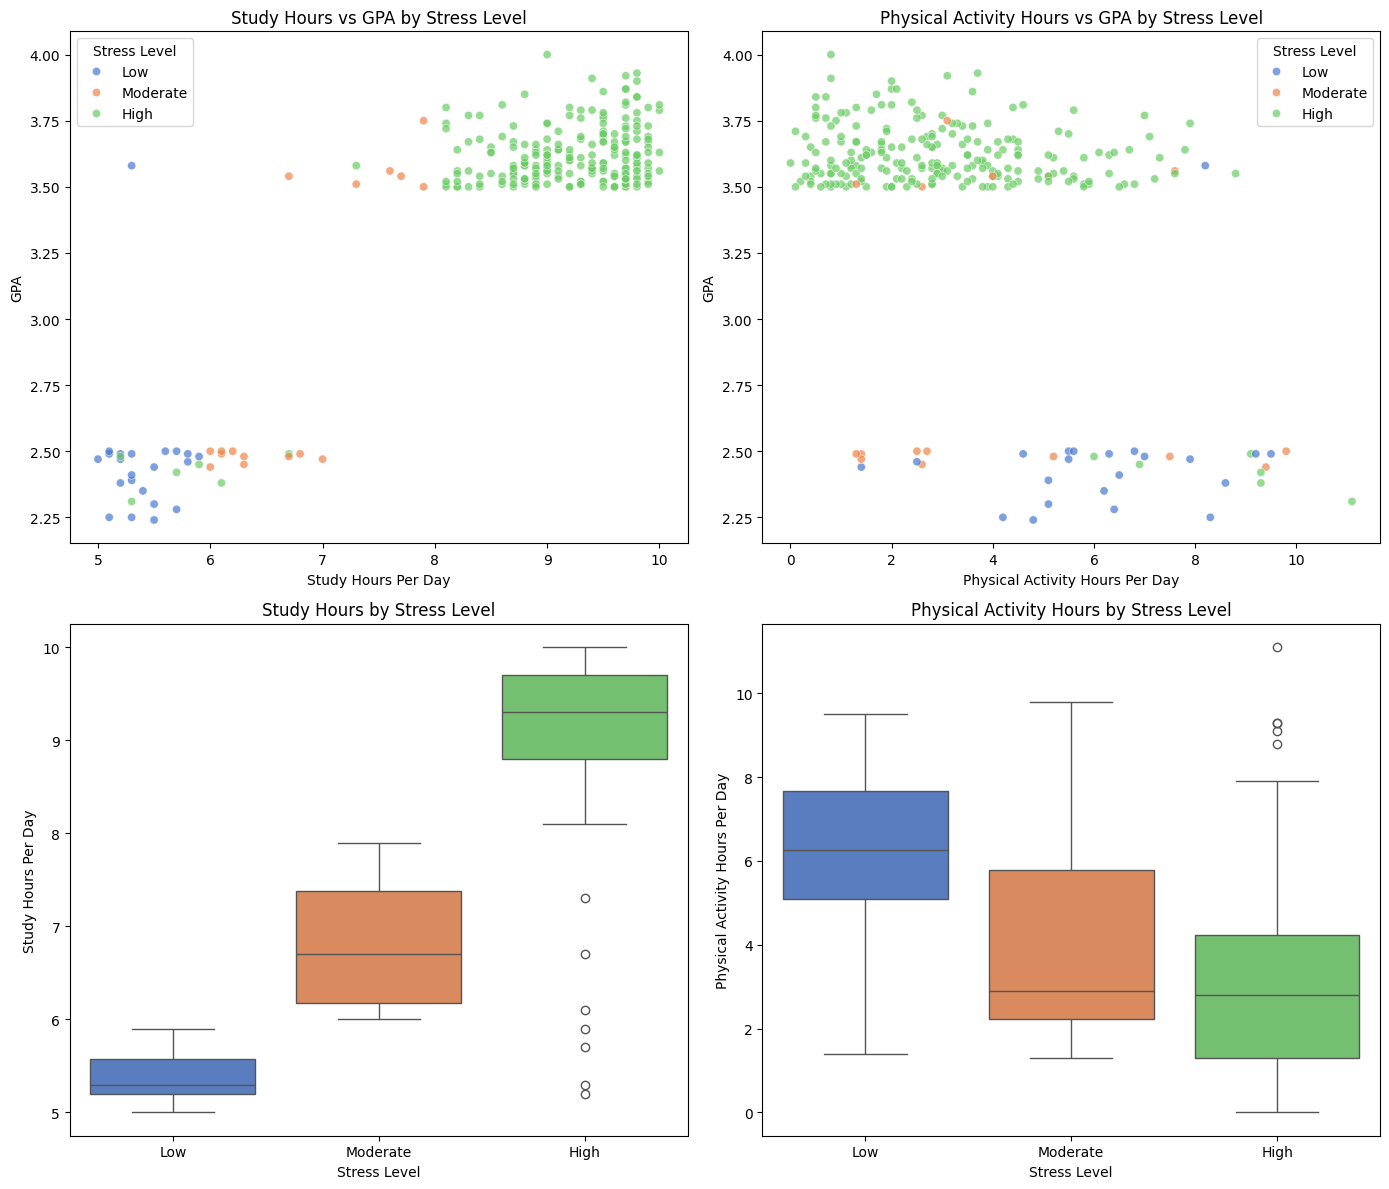

In [19]:
# Combine low and high GPA students for comparison
low_high_gpa_comparison = pd.concat([low_gpa_students, high_gpa_students])

# Create scatter plots to compare study hours and physical activity hours with stress level and GPA
plt.figure(figsize=(14, 12))

# Study Hours vs GPA
plt.subplot(2, 2, 1)
sns.scatterplot(
    x='Study_Hours_Per_Day', 
    y='GPA', 
    hue='Stress_Level', 
    data=low_high_gpa_comparison, 
    palette='muted', 
    alpha=0.7
)
plt.title('Study Hours vs GPA by Stress Level')
plt.xlabel('Study Hours Per Day')
plt.ylabel('GPA')
plt.legend(title='Stress Level')

# Physical Activity Hours vs GPA
plt.subplot(2, 2, 2)
sns.scatterplot(
    x='Physical_Activity_Hours_Per_Day', 
    y='GPA', 
    hue='Stress_Level', 
    data=low_high_gpa_comparison, 
    palette='muted', 
    alpha=0.7
)
plt.title('Physical Activity Hours vs GPA by Stress Level')
plt.xlabel('Physical Activity Hours Per Day')
plt.ylabel('GPA')
plt.legend(title='Stress Level')

# Study Hours vs Stress Level
plt.subplot(2, 2, 3)
sns.boxplot(
    x='Stress_Level', 
    y='Study_Hours_Per_Day', 
    data=low_high_gpa_comparison, 
    palette='muted'
)
plt.title('Study Hours by Stress Level')
plt.xlabel('Stress Level')
plt.ylabel('Study Hours Per Day')

# Physical Activity Hours vs Stress Level
plt.subplot(2, 2, 4)
sns.boxplot(
    x='Stress_Level', 
    y='Physical_Activity_Hours_Per_Day', 
    data=low_high_gpa_comparison, 
    palette='muted'
)
plt.title('Physical Activity Hours by Stress Level')
plt.xlabel('Stress Level')
plt.ylabel('Physical Activity Hours Per Day')

plt.tight_layout()
plt.show()

Insights on Stress Levels Among Low and High GPA Students

**Low GPA Students**

* **Low Stress:** 56.8% fall into this category, possibly reflecting less academic motivation or pressure.
* **Moderate Stress:** 27.0% experience moderate stress.
* **High Stress:** 16.2% face high stress, suggesting excessive stress can negatively affect performance.

**High GPA Students**

* **High Stress:** 96.8% experience high stress, indicating strong academic drive linked to stress.
* **Moderate Stress:** Only 2.7% report moderate stress.
* **Low Stress:** A tiny 0.5% report low stress, implying minimal stress rarely leads to top performance.

**Key Observations**

* **Stress and GPA:** High stress is common among high-achieving students, while low stress is typical among lower GPA students.
* **Moderate Stress:** Appears to support stable academic performance but is less prevalent among top performers.


In [20]:
# Identify the maximum and minimum GPA in the dataset
max_gpa = df['GPA'].max()
min_gpa = df['GPA'].min()

# Count the number of students with maximum and minimum GPA
num_students_max_gpa = df[df['GPA'] == max_gpa].shape[0]
num_students_min_gpa = df[df['GPA'] == min_gpa].shape[0]

max_gpa_info = {
    "Max GPA": max_gpa,
    "Number of Students with Max GPA": num_students_max_gpa
}

min_gpa_info = {
    "Min GPA": min_gpa,
    "Number of Students with Min GPA": num_students_min_gpa
}

print("--- GPA Summary Statistics ---\n")
print("Maximum GPA Information:")
for key, value in max_gpa_info.items():
    print(f"- {key}: {value}")

print("\nMinimum GPA Information:")
for key, value in min_gpa_info.items():
    print(f"- {key}: {value}")

--- GPA Summary Statistics ---

Maximum GPA Information:
- Max GPA: 4.0
- Number of Students with Max GPA: 1

Minimum GPA Information:
- Min GPA: 2.24
- Number of Students with Min GPA: 1


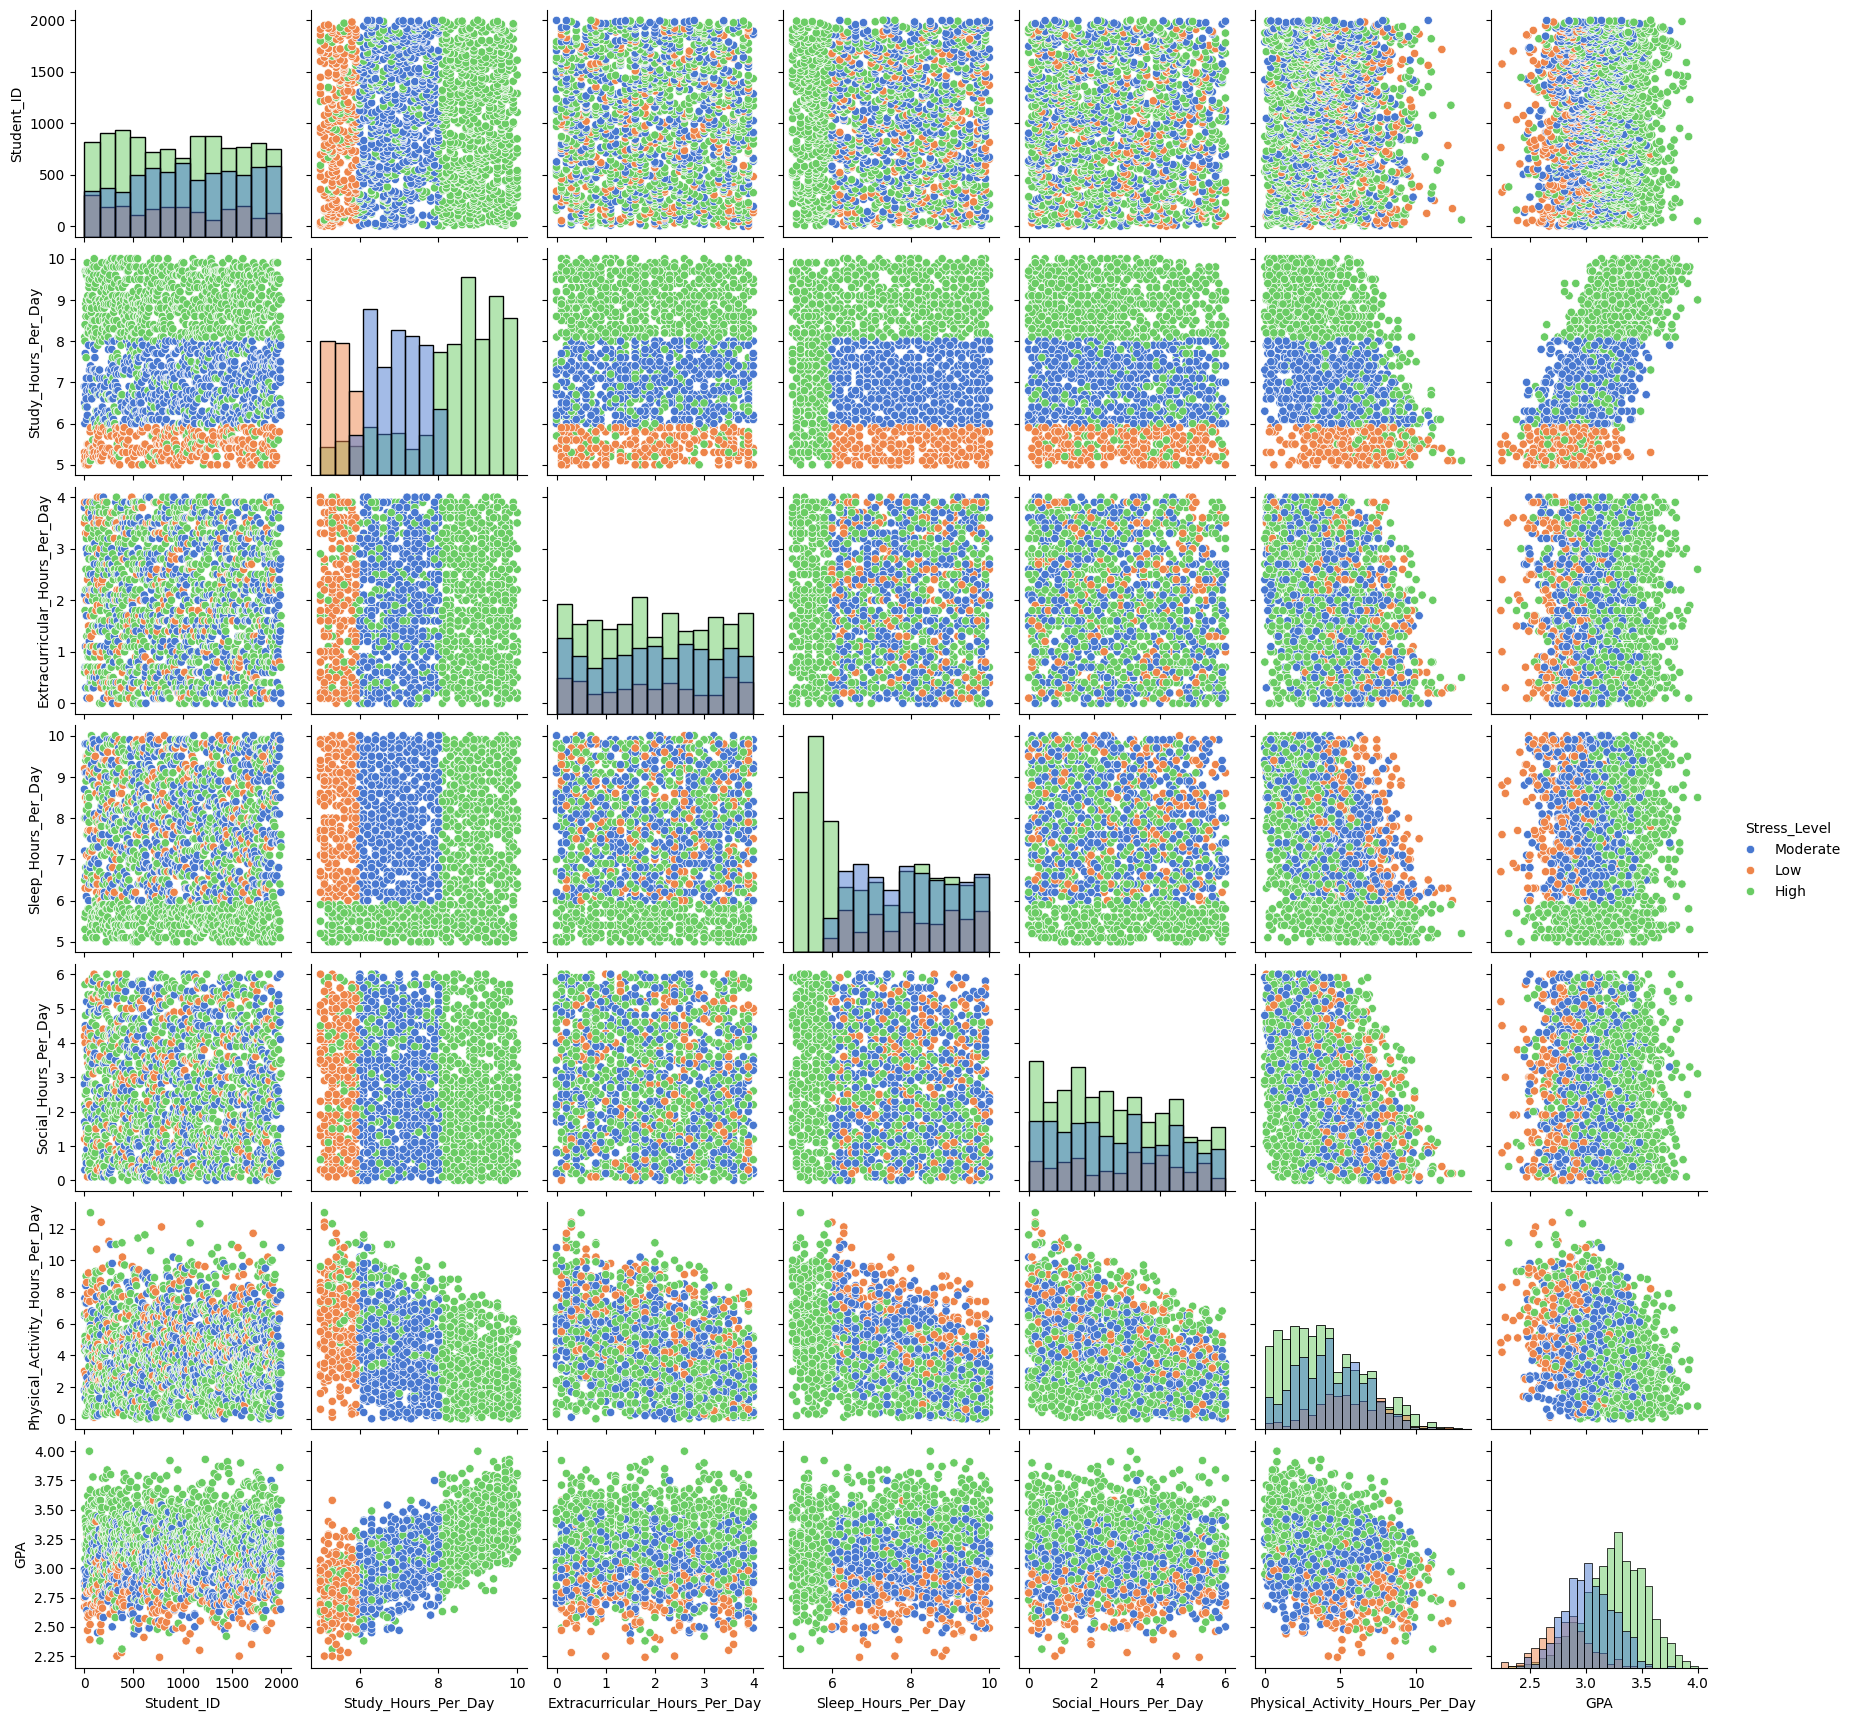

In [21]:
sns.pairplot(df, hue='Stress_Level', diag_kind='hist', palette='muted')

Insights from the PairPlot Visualization

**Stress-Level-Specific Observations**

* **High Stress:**

  * Students study more and tend to have higher GPAs.
  * Physical activity is generally lower among this group.

* **Moderate Stress:**

  * Displays a balanced combination of study hours, GPA, and physical activity.
  * Maintains a moderate GPA range.

* **Low Stress:**

  * Students study less, engage more in physical activities, and have lower GPAs.

**Key Observations**

* **High Stress Drives Performance:** Heavy focus on studying boosts GPA but reduces exercise time.
* **Moderate Stress Offers Balance:** Allows students to manage academics and physical activity, achieving decent GPAs.
* **Low Stress and Less Academic Focus:** Prioritizing physical activity over study is linked to lower academic outcomes.


# Data Preprocessing

Creating New Features for Deeper Insights

In [22]:
# Creating New Features for Deeper Insights

# Define a function to categorize academic performance based on GPA
def categorize_academic_performance(gpa):
    if gpa >= 3.5:
        return 'Excellent'
    elif 3.0 <= gpa < 3.5:  
        return 'Good'
    elif 2.0 <= gpa < 3.0:  
        return 'Fair'
    else:
        return 'Poor'

# Apply the function to create a new column for academic performance
df['Academic_Performance'] = df['GPA'].apply(categorize_academic_performance)

# Display the counts of each category for verification
academic_performance_counts = df['Academic_Performance'].value_counts()

# Display the results
academic_performance_counts

Academic_Performance
Good         1067
Fair          712
Excellent     221
Name: count, dtype: int64

Academic Performance Categorization

The **Academic Performance** feature has been grouped as follows:

* **Good (3.0 – 3.49):** 1,067 students
* **Fair (2.0 – 2.99):** 712 students
* **Excellent (3.5 – 4.0):** 221 students
* **Poor (< 2.0):** 0 students

This distribution shows that most students fall within the **Good** and **Fair** GPA ranges, with very few achieving **Excellent** scores and none in the **Poor** category.


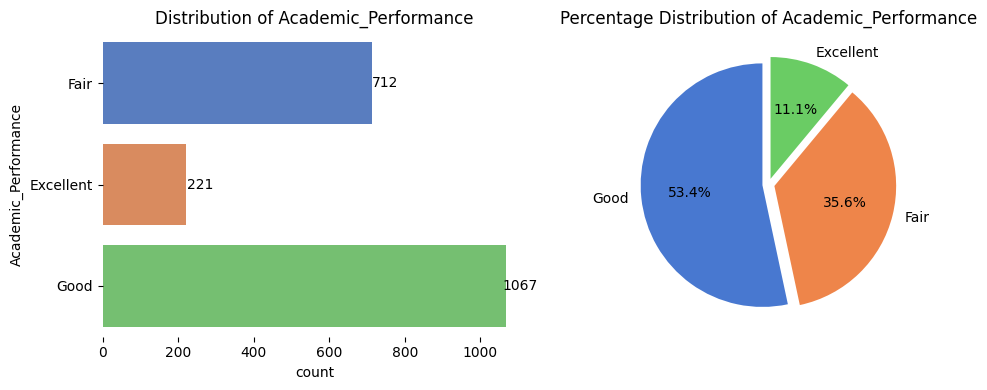

In [23]:
column_name = 'Academic_Performance'
plt.figure(figsize=(10, 4))

# First subplot: Count plot
plt.subplot(1, 2, 1)
sns.countplot(y=column_name, data=df, palette='muted')  
plt.title(f'Distribution of {column_name}')

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='center', va='center', xytext=(10, 0), textcoords='offset points')

sns.despine(left=True, bottom=True)

# Second subplot: Pie chart
plt.subplot(1, 2, 2)
df[column_name].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('muted'), startangle=90, explode=[0.05]*df[column_name].nunique())
plt.title(f'Percentage Distribution of {column_name}')
plt.ylabel('')  

plt.tight_layout()
plt.show()

Insights from Academic Performance Distribution

* **Good (53.4%):** Most students have a GPA between 3.0 – 3.49, making this the largest group.
* **Fair (35.6%):** A considerable portion falls in the 2.0 – 2.99 range.
* **Excellent (11.1%):** Only a small fraction achieves top GPAs of 3.5 – 4.0.
* **Poor (0%):** No students have a GPA below 2.0.

**Key Observations**

* The majority of students perform well academically but do not reach the highest level.
* There is potential to support "Good" students in improving toward the "Excellent" category.


In [24]:
# Encoding Stress_Level and Academic_Performance with explicit ordinal mappings

# Mapping for Stress_Level (ordinal encoding)
mapping_stress = {'Low': 0, 'Moderate': 1, 'High': 2}
df['Stress_Level_Encoded'] = df['Stress_Level'].map(mapping_stress)

# Mapping for Academic_Performance (ordinal encoding)
mapping_performance = {'Poor': 0, 'Fair': 1, 'Good': 2, 'Excellent': 3}
df['Academic_Performance_Encoded'] = df['Academic_Performance'].map(mapping_performance)

# Display the first few rows of the dataset to verify the new columns
df[['Stress_Level', 'Stress_Level_Encoded', 'Academic_Performance', 'Academic_Performance_Encoded']].head(10)

Stress_Level  Stress_Level_Encoded Academic_Performance  \
0     Moderate                     1                 Fair   
1          Low                     0                 Fair   
2          Low                     0                 Fair   
3     Moderate                     1                 Fair   
4         High                     2            Excellent   
5     Moderate                     1                 Fair   
6         High                     2                 Good   
7         High                     2                 Good   
8          Low                     0                 Fair   
9     Moderate                     1                 Fair   

   Academic_Performance_Encoded  
0                             1  
1                             1  
2                             1  
3                             1  
4                             3  
5                             1  
6                             2  
7                             2  
8                             1  
9                             1

In [25]:
# Drop the original categorical columns
df = df.drop(columns=['Stress_Level', 'Academic_Performance'])

# Verify the updated dataset
df.head()

Student_ID  Study_Hours_Per_Day  Extracurricular_Hours_Per_Day  \
0           1                  6.9                            3.8   
1           2                  5.3                            3.5   
2           3                  5.1                            3.9   
3           4                  6.5                            2.1   
4           5                  8.1                            0.6   

   Sleep_Hours_Per_Day  Social_Hours_Per_Day  Physical_Activity_Hours_Per_Day  \
0                  8.7                   2.8                              1.8   
1                  8.0                   4.2                              3.0   
2                  9.2                   1.2                              4.6   
3                  7.2                   1.7                              6.5   
4                  6.5                   2.2                              6.6   

    GPA  Stress_Level_Encoded  Academic_Performance_Encoded  
0  2.99                     1                             1  
1  2.75                     0                             1  
2  2.67                     0                             1  
3  2.88                     1                             1  
4  3.51                     2                             3

In [26]:
# Creating a table for correlation of the target variable 'Stress_Level_Encoded' with other features
target_variable = 'Stress_Level_Encoded'
target_correlation_table = df.corr()[[target_variable]].sort_values(by=target_variable, ascending=False)

# Displaying the table
target_correlation_table

Stress_Level_Encoded
Stress_Level_Encoded                         1.000000
Study_Hours_Per_Day                          0.738843
GPA                                          0.550395
Academic_Performance_Encoded                 0.504442
Student_ID                                   0.003306
Extracurricular_Hours_Per_Day               -0.006099
Social_Hours_Per_Day                        -0.054702
Physical_Activity_Hours_Per_Day             -0.205207
Sleep_Hours_Per_Day                         -0.298917

Insights from the Correlation Table (Target: Stress_Level_Encoded)

**Positive Correlations**

* **Study_Hours_Per_Day (0.7388):** Strongest positive correlation; students with higher stress tend to study more.
* **GPA (0.5504):** Moderate positive correlation; higher stress is linked to better academic performance.
* **Academic_Performance_Encoded (0.5044):** Students with higher stress often belong to higher academic categories (Good, Excellent).

**Weak Positive Correlation**

* **Student_ID (0.0033):** Negligible correlation, as expected.

**Negative Correlations**

* **Sleep_Hours_Per_Day (-0.2989):** Moderate negative correlation; higher stress reduces sleep duration.
* **Physical_Activity_Hours_Per_Day (-0.2052):** Students with higher stress engage in less exercise.
* **Social_Hours_Per_Day (-0.0547):** Slight negative correlation; high-stress students socialize a little less.
* **Extracurricular_Hours_Per_Day (-0.0061):** Very weak negative correlation; extracurricular activities have minimal effect on stress.


In [27]:
# Define the features (X) and the target variable (y)
X = df.drop(columns=['Student_ID', 'Stress_Level_Encoded'])  
y = df['Stress_Level_Encoded']  

# Display shapes to confirm the split
print("X Shape:", X.shape)
print("\ny Shape:", y.shape)

X Shape: (2000, 7)

y Shape: (2000,)


In [28]:
# Outlier detection using Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
outlier_predictions = iso_forest.fit_predict(X)

# Identify outliers: Isolation Forest marks outliers as -1
outlier_indices = X.index[outlier_predictions == -1]

# Print the number of outliers detected
print(f"Number of detected outliers: {len(outlier_indices)}")

Number of detected outliers: 20


In [29]:
# Remove outliers
X_filtered = X.drop(outlier_indices, axis=0).reset_index(drop=True)
y_filtered = y.drop(outlier_indices, axis=0).reset_index(drop=True)

print(f"New shape of X after removing outliers: {X_filtered.shape}")
print(f"New shape of y after removing outliers: {y_filtered.shape}")

New shape of X after removing outliers: (1980, 7)
New shape of y after removing outliers: (1980,)


In [30]:
# Save the preprocessed dataset (after encoding and outlier removal)
preprocessed_df = df.drop(index=outlier_indices).reset_index(drop=True)

preprocessed_dir = Path('../datasets/preprocessed')
preprocessed_dir.mkdir(parents=True, exist_ok=True)
preprocessed_path = preprocessed_dir / 'student_lifestyle_dataset_preprocessed.csv'
preprocessed_df.to_csv(preprocessed_path, index=False)

print(f"Preprocessed dataset saved to {preprocessed_path.resolve()}")

Preprocessed dataset saved to D:\projects\Nostressia\Current-Stress\datasets\preprocessed\student_lifestyle_dataset_preprocessed.csv


In [31]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Display the shapes of the splits for verification
print("X_train Shape:", X_train.shape)
print("X_test Shape:", X_test.shape)
print("y_train Shape:", y_train.shape)
print("y_test Shape:", y_test.shape)

X_train Shape: (1584, 7)
X_test Shape: (396, 7)
y_train Shape: (1584,)
y_test Shape: (396,)


In [32]:
# Apply RobustScaler
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Training and Evaluation

In [33]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Display model names to confirm initialization
print("Models initialized:", list(models.keys()))

Models initialized: ['Logistic Regression', 'Decision Tree', 'Random Forest']


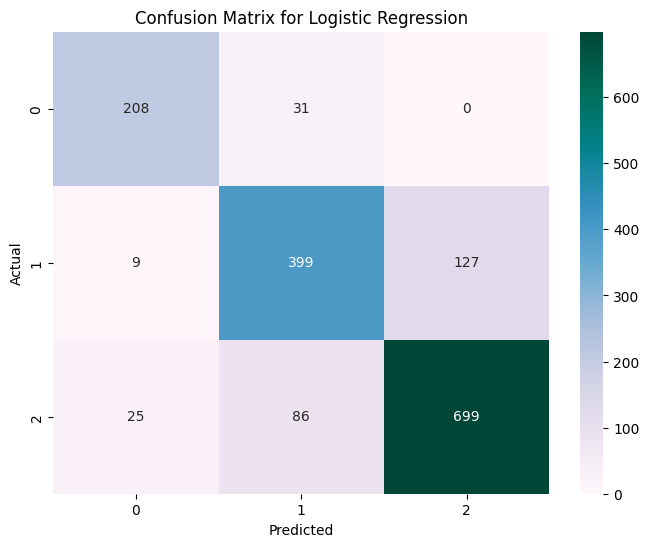


Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       239
           1       0.77      0.75      0.76       535
           2       0.85      0.86      0.85       810

    accuracy                           0.82      1584
   macro avg       0.83      0.83      0.83      1584
weighted avg       0.82      0.82      0.82      1584



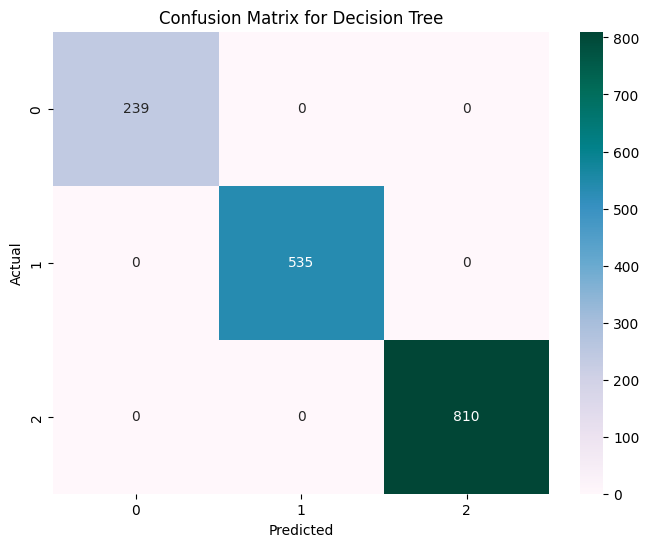


Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       239
           1       1.00      1.00      1.00       535
           2       1.00      1.00      1.00       810

    accuracy                           1.00      1584
   macro avg       1.00      1.00      1.00      1584
weighted avg       1.00      1.00      1.00      1584



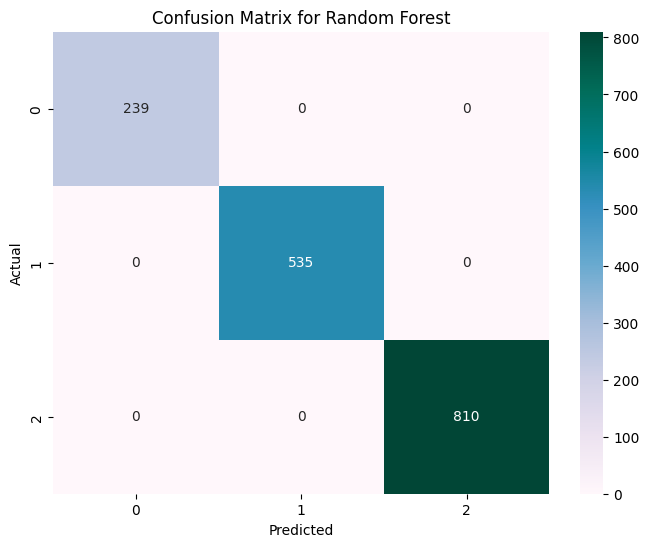


Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       239
           1       1.00      1.00      1.00       535
           2       1.00      1.00      1.00       810

    accuracy                           1.00      1584
   macro avg       1.00      1.00      1.00      1584
weighted avg       1.00      1.00      1.00      1584


Model Evaluation Summary:



Accuracy       AUC
Logistic Regression  0.824495  0.947523
Decision Tree        1.000000  1.000000
Random Forest        1.000000  1.000000

In [34]:
def train_and_evaluate_models(models, X_train, y_train, X_test, y_test):
    results = {}
    for name, model in models.items():
        # Train the model on the training data
        model.fit(X_train, y_train)

        # Predict on the test set
        preds = model.predict(X_test)

        # Calculate metrics on the training data
        accuracy = accuracy_score(y_train, model.predict(X_train))
        auc = (
            roc_auc_score(y_train, model.predict_proba(X_train), multi_class="ovr") 
            if hasattr(model, 'predict_proba') else 'N/A'
        )

        results[name] = {
            'Accuracy': accuracy,
            'AUC': auc,
            'Predictions': preds
        }

        # Display confusion matrix for training data
        conf_matrix = confusion_matrix(y_train, model.predict(X_train))
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='PuBuGn',
                    xticklabels=model.classes_, yticklabels=model.classes_)
        plt.title(f'Confusion Matrix for {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Display classification report for training data
        print(f"\nClassification Report for {name}:\n")
        print(classification_report(y_train, model.predict(X_train)))

    results_df = pd.DataFrame({
        name: {"Accuracy": results[name]["Accuracy"], "AUC": results[name]["AUC"]}
        for name in results
    }).T

    # Display the summary DataFrame
    print("\nModel Evaluation Summary:\n")
    return results_df

evaluation_summary = train_and_evaluate_models(models, X_train, y_train, X_test, y_test)

# Display the evaluation summary
evaluation_summary

Model Performance Observations

**Logistic Regression**

* Accuracy: 83%, AUC: 0.95
* Performs well and is highly interpretable.
* Slightly lower performance than tree-based models because it assumes linear relationships.

**Decision Tree**

* Accuracy and AUC: 100%
* Perfectly fits the training data, but may overfit and generalize poorly.

**Random Forest**

* Accuracy and AUC: 100%
* Offers better generalization than a single Decision Tree due to ensemble learning, while maintaining perfect training performance.


In [35]:
# Define the base models for stacking
base_models = [
    ('lr', LogisticRegression(random_state=42, max_iter=1000)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
]

# Define the meta-model for stacking
meta_model = RandomForestClassifier(random_state=42)

# Create the stacking classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

cv_scores = cross_val_score(stacking_model, X_train, y_train, cv=5, scoring='accuracy')

stacking_model.fit(X_train, y_train)

test_accuracy = stacking_model.score(X_test, y_test)

# Display the cross-validation scores and test accuracy
{
    "Cross-Validation Scores": cv_scores.tolist(),
    "Mean CV Accuracy": cv_scores.mean(),
    "Test Set Accuracy": test_accuracy
}

{'Cross-Validation Scores': [1.0, 1.0, 1.0, 1.0, 1.0],
 'Mean CV Accuracy': np.float64(1.0),
 'Test Set Accuracy': 1.0}

Stacking Model Observations

* The stacking model reached **perfect accuracy** on both cross-validation and the test set.
* This indicates that the ensemble effectively leverages the strengths of the base models—**Logistic Regression, Decision Tree, and Random Forest**—alongside the meta-model (**Random Forest**) to deliver optimal predictive performance.


Key Factors Driving Stress Predictions

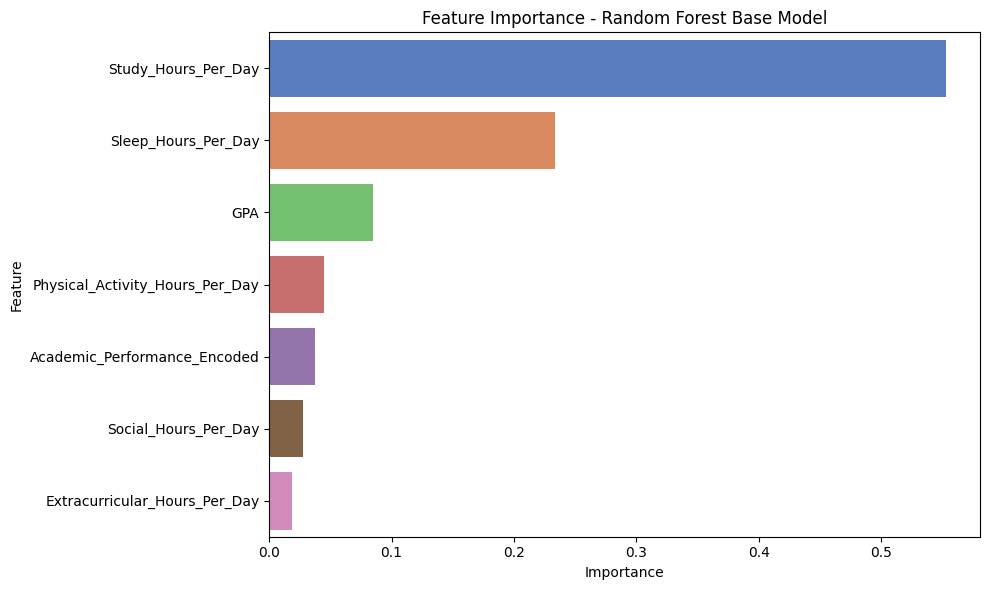

In [36]:
# Use the feature names from the original DataFrame
feature_names = X.columns  # Retrieve feature names from the original DataFrame

# Extract feature importance from the Random Forest base model
rf_base_model = stacking_model.named_estimators_['rf']  # Access Random Forest base model
rf_feature_importances = rf_base_model.feature_importances_

# Create a DataFrame to visualize feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='muted')
plt.title('Feature Importance - Random Forest Base Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


Feature Importance Insights

**Key Features Identified by the Random Forest Model:**

* **Study_Hours_Per_Day:**

  * The most influential feature for predicting stress.
  * More study hours are strongly linked to higher stress levels.

* **Sleep_Hours_Per_Day:**

  * Second most important feature.
  * Less sleep is associated with increased stress.

* **GPA:**

  * Academic performance affects stress patterns, likely due to academic pressure.

* **Physical_Activity_Hours_Per_Day:**

  * Moderately important.
  * More physical activity is linked to lower stress levels.

* **Academic_Performance_Encoded:**

  * Contributes to stress prediction, though less than GPA.

* **Social_Hours_Per_Day & Extracurricular_Hours_Per_Day:**

  * Least important features.
  * Socializing and extracurricular engagement have minimal direct impact on stress.

**Key Observations:**

* **Time Management:** Balancing study and sleep is crucial for stress reduction.
* **Health & Lifestyle:** Physical activity moderately helps manage stress.
* **Academic Pressure:** High GPA and academic demands contribute to stress, indicating the importance of academic support.


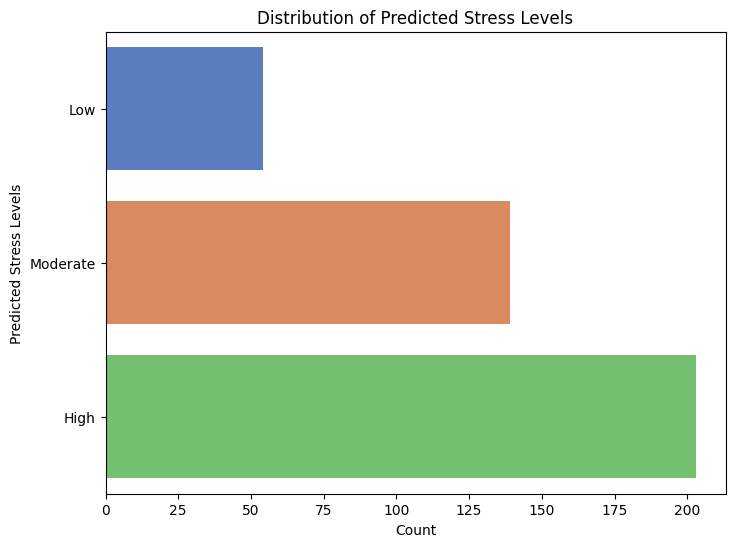

In [37]:
# Generate predictions on the test set using the stacking model
y_pred = stacking_model.predict(X_test)

# Map the encoded predictions back to the original stress level categories
mapping_stress_reverse = {0: 'Low', 1: 'Moderate', 2: 'High'}
y_pred_mapped = pd.Series(y_pred).map(mapping_stress_reverse)

# Plot the distribution of predicted stress levels
plt.figure(figsize=(8, 6))
sns.countplot(y=y_pred_mapped, palette='muted')
plt.title('Distribution of Predicted Stress Levels')
plt.xlabel('Count')
plt.ylabel('Predicted Stress Levels')
plt.show()

Predicted Stress Level Distribution Insights

* **High Stress:**

  * Most students in the test set are predicted to have high stress.
  * Indicates substantial academic or lifestyle pressures affecting students.

* **Moderate Stress:**

  * A significant portion falls into the moderate stress category.
  * Reflects a more balanced lifestyle where stress exists but is manageable.

* **Low Stress:**

  * Few students are predicted to have low stress.
  * Suggests that maintaining a low-stress routine is less common, possibly due to effective time management or less demanding circumstances.


In [38]:
# Save the trained stacking model, scaler, and feature names
model_artifacts = {
    'model': stacking_model,
    'scaler': scaler,
    'feature_names': feature_names
}

models_dir = Path('../models')
models_dir.mkdir(parents=True, exist_ok=True)
model_path = models_dir / 'current_stress_model.joblib'
joblib.dump(model_artifacts, model_path)

print(f"Model artifacts saved to {model_path.resolve()}")

Model artifacts saved to D:\projects\Nostressia\Current-Stress\models\current_stress_model.joblib
